In [1]:
from elastic_nerf.utils import wandb_utils as wu
from pathlib import Path
import pandas as pd
from IPython.display import display
from collections import defaultdict
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import asdict
import torch
from tqdm import tqdm as tqdm
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, Normalize, BoundaryNorm
from matplotlib import colormaps as colormaps
from matplotlib.colors import ListedColormap


class ColorConfig:
    def __init__(self):
        self.set3_cmap = plt.get_cmap("Set2")
        self.colors = [self.set3_cmap(i) for i in range(7)]
        self.cmap = ListedColormap(self.colors)
        self.buckets = np.array([0, 1, 2, 4, 8, 16, 32, 64])
        self.norm = BoundaryNorm(self.buckets, len(self.buckets))

    def get_color(self, width):
        return self.cmap(self.norm(width))

    def get_colorbar(self, ax):
        cb = plt.colorbar(
            cm.ScalarMappable(cmap=self.cmap, norm=self.norm),
            ticks=self.buckets,
            format="%.0f",
            ax=ax,
        )
        cb.ax.minorticks_off()
        return cb


sweep_mappings = {
    # "2uxektzo": "ngp_occ-mipnerf360-baseline",
    # "kebumdc0": "ngp_occ-mipnerf360-baseline",
    # "xxjsfkbw": "ngp_prop-mipnerf360-baseline",
    # "8w0wks0x": "ngp_prop-mipnerf360-baseline",
    # "qfkjdvv2": "ngp_occ-mipnerf360-sampling_single",
    # "hy03dx0e": "ngp_occ-mipnerf360-sampling",
    # "wsxh6gjo": "ngp_prop-mipnerf360-sampling",
    # "8ishbvau": "ngp_prop-mipnerf360-sampling_single",
    # "b674pjcs": "ngp_occ-mipnerf360-baseline_head_depth1",
    # "58hgroe5": "ngp_prop-mipnerf360-baseline_head_depth1",
    "c6g1mc5g": "ngp_occ-mipnerf360-baseline-mup",
    # "ccrwhsr5": "ngp_prop-mipnerf360-baseline-mup",
    "gy0qwrit": "ngp_prop-mipnerf360-baseline-mup-propv2",
}

# TR1e_mUP_Baseline_Propv2
This experiment is a redo of `tr1d_mup_baseline` except after _fixing the bug in Nerfacc where the proposal network 0 was not being trained_.

This experiment re-benchmarks the baseline models but this time, tries to train it "optimally" based on the principles of Maximal Update Parameterization. Recall that when we trained the baseline models previously in `tr1a_baseline_fused` and `tr1b_baseline`, we used the same learning rate for all the widths. However, this clearly can't be optimal. Even though we're operating at small scales (compared to the large models mUP was designed for, there's not a big difference between a width of 64 and a width of 8), if we were to hypothetically do a hyperparameter sweep over different widths, we would expect that the optimal learning rate for each width would be different. This additionally means that all of our previous benchmarking may have been for naught, since we were not training the models optimally.

More importantly, what we found in `tr1c_mrl_sampling` is that it's difficult to conclusively recommend a sampling strategy or loss weighting strategy or number of widths to subsample, purely based on the evaluation results. Not only is there a non-trivial amount of variance between configs, but there's even a lot of variance between runs of the same config with different or even identical random seeds! While we've tried implementing a number of strategies to mitigate this (such as pre-computing the sampling schedule and the loss weight schedule, as well as the dataset iteration order), it seems that there's some amount of randomness coming from tiny-cuda-nn, leading to the non-determinism. To get around this, we train each config 3 times with random seeds and report the mean and standard deviation of the evaluation results. We also train each config on all scenes from the MipNeRF-360 dataset, since we previously found in `tr1a_baseline_fused` and `tr1b_baseline` that trends in performance were not consistent across scenes.

In [3]:
tables = ["EvalResultsSummarytable"]
sweeps = sweep_mappings.keys()
results_cache_dir = Path("/home/user/shared/results/elastic-nerf")
sweep_results = {}

for sweep in sweeps:
    sweep_results[sweep] = wu.fetch_sweep_results(
        sweep=sweep,
        refresh_sweep_cache=False,
        refresh_run_cache=False,
        download_history=True,
        tables=tables,
    )
all_history = []
# Create a dataframe with all the results
for sweep_name in sweep_results:
    for run in sweep_results[sweep_name]:
        # Flatten the config
        flat_config = wu.flatten_dict(run.config, sep="-")
        # Concatenate the config with each row of the history results
        # Note that history results are already a dataframe
        history = run.history
        history["sweep_id"] = sweep_name
        history["run_id"] = run.run_id
        history["model_type"] = (
            "Nerfacc Prop" if "prop" in sweep_mappings[sweep_name] else "Nerfacc Occ"
        )
        history["sweep_name"] = sweep_mappings[sweep_name]
        for key in flat_config:
            try:
                history[key] = str(flat_config[key])
            except:
                print(f"Failed to add {key} to history with value {flat_config[key]}")
                raise
        all_history.append(history)

# %%
# Concatenate all the history results into a single dataframe
final_df = pd.concat(all_history, ignore_index=True)


# %%
fp = f"results_tr1e_mup_baseline-propv2.csv"
final_df.to_csv(fp, index=False)
print(f"Saved results to {fp}")
df = pd.read_csv(fp)

(gonas) [INFO] Downloaded history for run s72wg4jh
(gonas) [INFO] Downloaded history for run k9r5bwfw
(gonas) [INFO] Downloaded history for run s9t99c6b
(gonas) [INFO] Downloaded history for run z1mk9j9v
(gonas) [INFO] Downloaded history for run vuh6g4vp
(gonas) [INFO] Downloaded history for run e8va9a0s
(gonas) [INFO] Downloaded history for run 97e0pzrp
(gonas) [INFO] Downloaded history for run qdu10m3c
(gonas) [INFO] Downloaded history for run 72v75o38
(gonas) [INFO] Downloaded history for run xv0ue95h
wandb:   1 of 1 files downloaded.  
(gonas) [INFO] Downloaded table run-k9r5bwfw-EvalResultsSummarytable for run k9r5bwfw to /home/user/shared/results/elastic-nerf/runs/k9r5bwfw/EvalResultsSummarytable_v0
(gonas) [INFO] Downloaded tables dict_keys(['EvalResultsSummarytable_v0']) for run k9r5bwfw.
wandb:   1 of 1 files downloaded.  
(gonas) [INFO] Downloaded table run-s9t99c6b-EvalResultsSummarytable for run s9t99c6b to /home/user/shared/results/elastic-nerf/runs/s9t99c6b/EvalResultsSum

Saved results to results_tr1e_mup_baseline-propv2.csv


/tmp/ipykernel_743944/2131966945.py:46: DtypeWarning: Columns (211,213,217,222,226,227) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fp)


# Results
## Sampling Strategy
First, let's take a look at the average results across 3 random seeds. Note how now we don't have the weird results for the Stump scene anymore, where for widths 16 and 8, it was almost 40% worse than the baseline. That being said, if we take a close look at the results for the full-width model (e.g. for `NGP Occ Stump`), you can see that it is almost 1 PSNR lower than our previous result. That being said, I'm not sure which is the more accurate result, since the previous result was only trained once, and this result is the average of 3 runs.

After fixing our proposal network bug though, the Nerfacc Prop results look pretty good.

The real question is whether or not this was trained optimally? Because if so, then it's more likely that this will be a consistent result, in which case, we should be able to get additional improvements by simply training for longer. Also note that we applied mUP by assuming that the width 8 model was the baseline, and then scaled the learning rate/initialization variance accordingly. However, keep in mind that the "base" hyperparameters we're using were actually selected for a width 64 model, which implies that the learning rate for the width 8 model is too low (and subsequently, the learning rate for the larger widths are even lower. )

In [4]:
num_scenes = len(df["scene"].unique())
table_cols = ["Head Depth", "Scene", "Width 64", "Width 32", "Width 16", "Width 8"]
for i, (model_type, model_group) in enumerate(df.groupby(by="model_type")):
    model_group = model_group.query("_step == 20000")
    for k, (head_depth, head_depth_group) in enumerate(
        model_group.groupby(by="radiance_field-head_depth")
    ):
        table_data = []
        for j, (scene, scene_group) in enumerate(head_depth_group.groupby(by="scene")):
            base_psnr = model_group.query(
                "_step == 20000 and hidden_dim == 64 and scene == @scene and `radiance_field-head_depth` == 2"
            )["Eval Results Summary/psnr_avg/elastic_64"].mean()
            table_row = {"Scene": scene.capitalize(), "Head Depth": f"{head_depth}"}
            for dim, dim_group in scene_group.groupby(by="hidden_dim"):
                psnr_col = f"Eval Results Summary/psnr_avg/elastic_{dim}"
                psnr_avg = dim_group[psnr_col].mean()
                psnr_std = dim_group[psnr_col].std()
                pc_diff = 100 * (psnr_avg - base_psnr) / base_psnr
                if dim == 64 and head_depth == 2:
                    table_row.update({f"Width {dim}": f"{psnr_avg:.2f}"})
                else:
                    table_row.update(
                        {
                            f"Width {dim}": f"{psnr_avg:.2f}±{psnr_std:.2f} ({pc_diff:.2f}%)"
                        }
                    )
            table_data.append(table_row)

        table_data = pd.DataFrame(table_data, columns=table_cols)
        caption = (
            f"PSNR values after 20k steps of training for {model_type} model (with Radiance Field head MLP depth = {head_depth}) at different widths across scenes from the MipNeRF-360 dataset."
            f"  Values in brackets are the percentage difference compared to the baseline PSNR for each model at full-size (width 64) and Radiance Field Head MLP depth 2 (default model)."
        )
        table_data = table_data.style.set_caption(caption)
        display(table_data)
    # print(
    #     table_data.to_latex(
    #         index=False,
    #         caption=f"Baseline performance (PSNR) after 20k steps of training for {model_type_name} model at different widths across scenes from the MipNeRF-360 dataset",
    #         label=f"tab:baseline_{model_type_name.replace(' ', '_')}",
    #         position="h",
    #         column_format="lcccccc",
    #         escape=True,
    #         bold_rows=True,
    #     )
    # )

# LaTeX table for Head Depth 2

In [15]:
num_scenes = len(df["scene"].unique())
table_cols = ["Scene", "Width 64", "Width 32", "Width 16", "Width 8"]

header_row1 = [
    "\multicolumn{4}{c}{NGP Occ} & \\multicolumn{4}{c}{NGP Prop} \\\\",
]
header_row2 = [
    "\\textbf{Scene}",
    "Width 64",
    "Width 32",
    "Width 16",
    "Width 8",
    "Width 64",
    "Width 32",
    "Width 16",
    "Width 8",
]
header = (
    " & ".join(header_row1)
    + " \\midrule \n"
    + " & ".join(header_row2)
    + " \\\\ \\midrule"
)

table_data = []

base_psnrs = defaultdict(dict)
for j, (scene, scene_group) in enumerate(df.groupby(by="scene")):
    table_row = ["\\textbf{" + scene.capitalize() + "}"]  # Scene names in bold
    for i, (model_type, model_group) in enumerate(scene_group.groupby(by="model_type")):
        model_group = model_group.query("_step == 20000")
        model_group = model_group[model_group["radiance_field-head_depth"] == 2]
        base_psnr = model_group.query("hidden_dim == 64")[
            "Eval Results Summary/psnr_avg/elastic_64"
        ].mean()
        base_psnrs[scene][model_type] = base_psnr
        for dim in [64, 32, 16, 8]:
            dim_group = model_group.query(f"hidden_dim == {dim}")
            psnr_col = f"Eval Results Summary/psnr_avg/elastic_{dim}"
            psnr_avg = dim_group[psnr_col].mean()
            psnr_std = dim_group[psnr_col].std()
            pc_diff = 100 * (psnr_avg - base_psnr) / base_psnr
            if dim == 64:
                table_row.append(f"{psnr_avg:.2f}±{psnr_std:.2f}")
            else:
                table_row.append(f"{psnr_avg:.2f}±{psnr_std:.2f} ({pc_diff:.1f}\\%)")
    table_data.append(table_row)

# Converting the Python list of lists to a LaTeX table
table_body = " \\\\\n".join([" & ".join(row) for row in table_data]) + " \\\\"

# Combining the header and body to form the final table
final_table = (
    "\\begin{table*}[h]\n\\centering\n\\small\n"
    "\\caption{Combined Baseline PSNR after 20k steps of training optimally with mUP for NGP Occ and NGP Prop models (with depth of 2 for the Radiance Field head MLP) at different widths across scenes from the MipNeRF-360 dataset}\n"
    "\\label{tab:combined_baseline_NGP}\n"
    "\\begin{tabular}{lcccc|cccc}\n\\toprule\n"
    + header
    + "\n"
    + table_body
    + "\n\\bottomrule\n"
    "\\end{tabular}\n\\end{table*}"
)
print(final_table)

\begin{table*}[h]
\centering
\small
\caption{Combined Baseline PSNR after 20k steps of training optimally with mUP for NGP Occ and NGP Prop models (with depth of 2 for the Radiance Field head MLP) at different widths across scenes from the MipNeRF-360 dataset}
\label{tab:combined_baseline_NGP}
\begin{tabular}{lcccc|cccc}
\toprule
\multicolumn{4}{c}{NGP Occ} & \multicolumn{4}{c}{NGP Prop} \\ \midrule 
\textbf{Scene} & Width 64 & Width 32 & Width 16 & Width 8 & Width 64 & Width 32 & Width 16 & Width 8 \\ \midrule
\textbf{Bicycle} & 22.40±0.01 & 22.30±0.04 (-0.5\%) & 22.04±0.04 (-1.6\%) & 21.75±0.09 (-2.9\%) & 23.25±0.00 & 23.10±0.02 (-0.6\%) & 22.87±0.09 (-1.6\%) & 22.43±0.01 (-3.5\%) \\
\textbf{Bonsai} & 29.81±0.07 & 29.46±0.08 (-1.2\%) & 28.67±0.07 (-3.8\%) & 28.02±0.06 (-6.0\%) & 31.59±0.03 & 30.67±0.23 (-2.9\%) & 29.34±0.21 (-7.1\%) & 28.52±0.77 (-9.7\%) \\
\textbf{Counter} & 26.86±0.02 & 26.61±0.04 (-0.9\%) & 26.20±0.08 (-2.4\%) & 25.60±0.09 (-4.7\%) & 27.64±0.09 & 26.49±0.01 (-4.1\

# LaTeX table for Head Depth 1

In [16]:
num_scenes = len(df["scene"].unique())
table_cols = ["Scene", "Width 64", "Width 32", "Width 16", "Width 8"]

header_row1 = [
    "\multicolumn{4}{c}{NGP Occ} & \\multicolumn{4}{c}{NGP Prop} \\\\",
]
header_row2 = [
    "\\textbf{Scene}",
    "Width 64",
    "Width 32",
    "Width 16",
    "Width 8",
    "Width 64",
    "Width 32",
    "Width 16",
    "Width 8",
]
header = (
    " & ".join(header_row1)
    + " \\midrule \n"
    + " & ".join(header_row2)
    + " \\\\ \\midrule"
)

table_data = []

for j, (scene, scene_group) in enumerate(df.groupby(by="scene")):
    table_row = ["\\textbf{" + scene.capitalize() + "}"]  # Scene names in bold
    for i, (model_type, model_group) in enumerate(scene_group.groupby(by="model_type")):
        model_group = model_group.query("_step == 20000")
        model_group = model_group[model_group["radiance_field-head_depth"] == 1]
        base_psnr = base_psnrs[scene][model_type]
        for dim in [64, 32, 16, 8]:
            dim_group = model_group.query(f"hidden_dim == {dim}")
            psnr_col = f"Eval Results Summary/psnr_avg/elastic_{dim}"
            psnr_avg = dim_group[psnr_col].mean()
            psnr_std = dim_group[psnr_col].std()
            if psnr_std < 1:
                psnr_std = "." + f"{psnr_std:.2f}".split(".")[1]

            else:
                psnr_std = f"{psnr_std:.2f}"
            pc_diff = 100 * (psnr_avg - base_psnr) / base_psnr
            table_row.append(f"{psnr_avg:.2f}±{psnr_std} ({pc_diff:.1f}\\%)")
    table_data.append(table_row)

# Converting the Python list of lists to a LaTeX table
table_body = " \\\\\n".join([" & ".join(row) for row in table_data]) + " \\\\"

# Combining the header and body to form the final table
final_table = (
    "\\begin{table*}[h]\n\\centering\n\\scriptsize\n"
    "\\caption{Combined Baseline PSNR after 20k steps of training optimally with mUP for NGP Occ and NGP Prop models (with depth of 1 for the Radiance Field head MLP) at different widths across scenes from the MipNeRF-360 dataset}\n"
    "\\label{tab:combined_baseline_NGP}\n"
    "\\begin{tabular}{lcccc|cccc}\n\\toprule\n"
    + header
    + "\n"
    + table_body
    + "\n\\bottomrule\n"
    "\\end{tabular}\n\\end{table*}"
)
print(final_table)

\begin{table*}[h]
\centering
\scriptsize
\caption{Combined Baseline PSNR after 20k steps of training optimally with mUP for NGP Occ and NGP Prop models (with depth of 1 for the Radiance Field head MLP) at different widths across scenes from the MipNeRF-360 dataset}
\label{tab:combined_baseline_NGP}
\begin{tabular}{lcccc|cccc}
\toprule
\multicolumn{4}{c}{NGP Occ} & \multicolumn{4}{c}{NGP Prop} \\ \midrule 
\textbf{Scene} & Width 64 & Width 32 & Width 16 & Width 8 & Width 64 & Width 32 & Width 16 & Width 8 \\ \midrule
\textbf{Bicycle} & 22.35±.04 (-0.2\%) & 22.24±.04 (-0.7\%) & 22.03±.07 (-1.7\%) & 21.79±.07 (-2.7\%) & 23.25±.02 (0.0\%) & 23.05±.04 (-0.9\%) & 22.77±.08 (-2.1\%) & 22.52±.09 (-3.1\%) \\
\textbf{Bonsai} & 29.58±.07 (-0.8\%) & 29.11±.08 (-2.3\%) & 28.58±.01 (-4.1\%) & 28.12±.25 (-5.7\%) & 30.98±.63 (-1.9\%) & 30.67±.30 (-2.9\%) & 29.82±.56 (-5.6\%) & 28.13±.22 (-10.9\%) \\
\textbf{Counter} & 26.82±.04 (-0.1\%) & 26.57±.03 (-1.1\%) & 26.19±.05 (-2.5\%) & 25.52±.18 (-5.0\%) & 

# Exploring the results from the perspective of Maximal Update Parameterization

Previously during our initial explorations into mUP, we arrived at the following conclusions for a simple MLP with 2 hidden layers:
### Layer 1
Init variance:
- Target variance is 0.5, target std is 0.7, actual variance approaches 0.5 as n→inf
- Standard xavier normal initialization has std which seems to scale as $\sqrt{\frac{2}{fanin + fanout}}$ 
	- So as fanout → inf (this is our width), std gets smaller and smaller
	- Instead, mup says that it should only scale as a function of `1/fan_in` (which for us scales O(1)) so we end up with a constant init var for input weight across all widths. **Thus we set target variance to 0.5**
	- Under the hood, mup multiplies the standard scale by $\sqrt{\frac{fanout + fanin}{fanoutBase + faninBase}}$
		- $\therefore \sqrt{\frac{2}{fanin + fanout}} \cdot \sqrt{\frac{fanout + fanin}{fanoutBase + faninBase}}$
		- $\sqrt{\frac{2}{3 + fanout}} \cdot \sqrt{\frac{fanout + 3}{1 + 3}} = \sqrt{\frac{2}{4}} = \sqrt{0.5}$
		- $\therefore Var = \sigma^{2} = 0.5$
Multiplier:
- `fan_in.width_mult` scales constantly O(1)
- but the shape’s width_mult seems to scale linearly? _O(n)_?
Learning rate:
- LR scales constantly O(1) (**so same as global LR**) for **Adam**

### Layer 2 (Hidden Layer)
Init variance:
- Xavier initialization by default scales init variance scale as $\sqrt{\frac{2}{fanin + fanout}}$ 
- But mup first scales the usual std by $\sqrt{\frac{fanout + fanin}{fanoutBase + faninBase}}$
	- and then for weights with 2 infinite dimensions (i.e. hidden layer weights where both fanin and fanout are infinite), it additionally divides it by $\sqrt{faninWidthMult}$
	- $\therefore \sqrt{\frac{2}{fanin + fanout}} \cdot \sqrt{\frac{fanout + fanin}{fanoutBase + faninBase}} / \sqrt{faninWidthMult}$
	- Note that in our case, we have a square matrix so `fanin.dim == fanout.dim == width`. Also `fan_in.width_mult() == width` since our base network was “pure” with `width==1`
	- $\therefore \sqrt{\frac{2}{width + width}} \cdot \sqrt{\frac{width + width}{1 + 1}} \cdot \frac{1}{\sqrt{faninWidthMult}} =  \frac{1}{\sqrt{faninWidthMult}}$
	- Note that this ends up being the same as the default initialization because $\sqrt{\frac{2}{fanin + fanout}} = \sqrt{\frac{1}{width}} = \sqrt{\frac{1}{faninWidthMult}}$ 
	- **This doesn’t match up with Table 8 which says for hidden weights, init variance scales `1/fan_in`?**

Multiplier:
- both `fan_in.width_mult()` and `width_mult` scale linearly O(n)? But then why does **Table 8 say the multiplier is 1?**

Learning Rate:
- We set the global learning rate to 0.1
- mup Adam scales the global lr by $\frac{1}{fanin}$ (or in the code, divides the `group['lr'] /= width_mult)
- This matches up with all the tables which say for hidden weights, scale the global LR by $lr = gLR \cdot \frac{1}{fanin}$ 

### Readout (Output Layer)
Init variance:
- Recall that mup scales the usual std by $\sqrt{\frac{fanout + fanin}{fanoutBase + faninBase}}$
	- Thus, we get $\sqrt{\frac{2}{fanin + fanout}} \cdot \sqrt{\frac{fanout + fanin}{fanoutBase + faninBase}}$
	- $= \sqrt{\frac{2}{width + 16}} \cdot \sqrt{\frac{16 + width}{16 + 1}} = \sqrt{\frac{2}{fanout +1}} = \sqrt{\frac{2}{17}}$ 
- This matches up with Table 

## Training Dynamics

Let's take a look at the training dynamics for the width 64 baseline models after training them with mUP. Specifically, we want to see if the spectral norm scaling stays constant as the width increases (as they claim it should).

In [6]:
def make_df_for_run(
    weight_norms, grad_norms, config, model_type, steps, sweep_id, run_id
):
    results_all = []
    num_steps = 43
    num_widths = 64
    module_names = list(weight_norms.keys())
    flattened_config = wu.flatten_dict(asdict(config), sep=".")
    for step_idx in range(num_steps):
        base_width = 8
        for width_idx in range(num_widths):
            for module_name in module_names:
                try:
                    results = {
                        "step": steps[step_idx],
                        "width": width_idx + 1,
                        "module": module_name,
                        "sweep_id": sweep_id,
                        "run_id": run_id,
                        "model_type": model_type,
                    }
                    results.update(flattened_config)
                    for metric_type in [
                        "L1",
                        "Frobenius",
                        "Spectral (max)",
                        "Spectral (min)",
                    ]:
                        if (
                            len(weight_norms[module_name][metric_type]["1D"][step_idx])
                            < num_widths
                        ):
                            # If the module wasn't elastic, we don't compute the norms for it
                            weight = None
                            weight_scaled = None
                        else:
                            weight = weight_norms[module_name][metric_type]["1D"][
                                step_idx
                            ][width_idx]
                            base_weight = weight_norms[module_name][metric_type]["1D"][
                                step_idx
                            ][base_width - 1]

                            weight_scaled = (
                                weight / base_weight if base_weight > 0 else None
                            )

                        if (
                            step_idx == 0
                            or len(
                                grad_norms[module_name][metric_type]["1D"][step_idx - 1]
                            )
                            < num_widths
                        ):
                            grad = None
                            grad_scaled = None
                        else:
                            grad = grad_norms[module_name][metric_type]["1D"][
                                step_idx - 1
                            ][width_idx]
                            grad_base = grad_norms[module_name][metric_type]["1D"][
                                step_idx - 1
                            ][base_width - 1]
                            grad_scaled = grad / grad_base if grad_base > 0 else None
                        results.update(
                            {
                                f"weight/{metric_type}": weight,
                                f"weight_scaled/{metric_type}": weight_scaled,
                                f"grad/{metric_type}": grad,
                                f"grad_scaled/{metric_type}": grad_scaled,
                            }
                        )
                    results_all.append(results)
                except Exception as e:
                    print(
                        f"Encountered error at step {step_idx}, width {width_idx}, metric {metric_type} for {module_name}: {e}"
                    )
                    raise e

    return pd.DataFrame(results_all)


log_dir = Path("/home/user/shared/results/elastic-nerf")
wandb_dir = Path("/home/user/shared/wandb_cache/elastic-nerf")
results_cache_dir = Path("/home/user/shared/results/elastic-nerf")

COMPUTE_TRAINING_DYNAMICS_DF = False
if COMPUTE_TRAINING_DYNAMICS_DF:
    dfs = []
    for sweep_id in sweep_mappings.keys():
        sweep = wu.fetch_sweep(sweep_id)
        for run in tqdm(sweep.runs):
            training_dynamics_path = (
                results_cache_dir / run.id / "weights_grads/training_dynamics.pt"
            )
            training_dynamics = torch.load(training_dynamics_path)
            weight_norms = training_dynamics["weight_norms"]
            grad_norms = training_dynamics["grad_norms"]
            steps = training_dynamics["training_steps"]
            config = training_dynamics["config"]
            model_type = training_dynamics["model_type"]
            try:
                df = make_df_for_run(
                    weight_norms,
                    grad_norms,
                    config,
                    model_type,
                    steps,
                    sweep_id,
                    run.id,
                )
                dfs.append(df)
                print(f"Processed run {run.id} from sweep {sweep_id}")
            except Exception as e:
                print(f"Failed to process run {run.id} from sweep {sweep_id}: {e}")

    df = pd.concat(dfs)
    df.to_csv("tr1d_mup_baseline_training_dynamics.csv", index=False)
    cols = [
        "seed",
        "step",
        "width",
        "module",
        "sampling_strategy",
        "loss_weight_strategy",
        "radiance_field.use_elastic",
        "radiance_field.use_elastic_head",
        "radiance_field.head_depth",
        "density_field.use_elastic",
        "num_widths_to_sample",
        "model_type",
        "num_train_widths",
        "duplicate_train_batch_across_widths",
        "run_id",
        "sweep_id",
        "dataset.scene",
        "hidden_dim",
        "adjust_lr_for_duplicate_train_batch",
        "max_steps",
        "num_eval_elastic_widths",
        "fused_eval",
        "host_machine",
        "weight/L1",
        "weight_scaled/L1",
        "grad/L1",
        "grad_scaled/L1",
        "weight/Frobenius",
        "weight_scaled/Frobenius",
        "grad/Frobenius",
        "grad_scaled/Frobenius",
        "weight/Spectral (max)",
        "weight_scaled/Spectral (max)",
        "grad/Spectral (max)",
        "grad_scaled/Spectral (max)",
        "weight/Spectral (min)",
        "weight_scaled/Spectral (min)",
        "grad/Spectral (min)",
        "grad_scaled/Spectral (min)",
    ]
    df[cols].to_csv("tr1d_mup_baseline_training_dynamics_filtered.csv", index=False)
else:
    df = pd.read_csv("tr1d_mup_baseline_training_dynamics_filtered.csv")

/tmp/ipykernel_495703/287180874.py:162: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("tr1d_mup_baseline_training_dynamics_filtered.csv")


In [7]:
for scene, scene_group in df.groupby(by="dataset.scene"):
    for model_type, model_type_group in scene_group.groupby(by="model_type"):
        for head_depth, head_depth_group in model_type_group.groupby(
            by="radiance_field.head_depth"
        ):
            for hidden_dim, hidden_dim_group in head_depth_group.groupby(
                by="hidden_dim"
            ):
                for module, module_group in hidden_dim_group.groupby(by="module"):
                    pass

As expected, **the scaled norms do not provide any useful information in this case, since we're scaling with respect to the base width (of 8) which was never explicitly optimized**. Instead, the scale ratios we expect should be obtained by comparing against the training dynamics of a baseline width 8 model (one with hidden dim 8, not just one where we splice a layer width of 8). However, note that between different seeds, the width 64 training dynamics are somewhat consistent in shape. I think it would be useful to visualize just the width 64 norm across steps. Basically in each plot, we want to see the width 64 metric for all 3 seeds, each subplot should show a different metric, and each subfigure should show a different module.

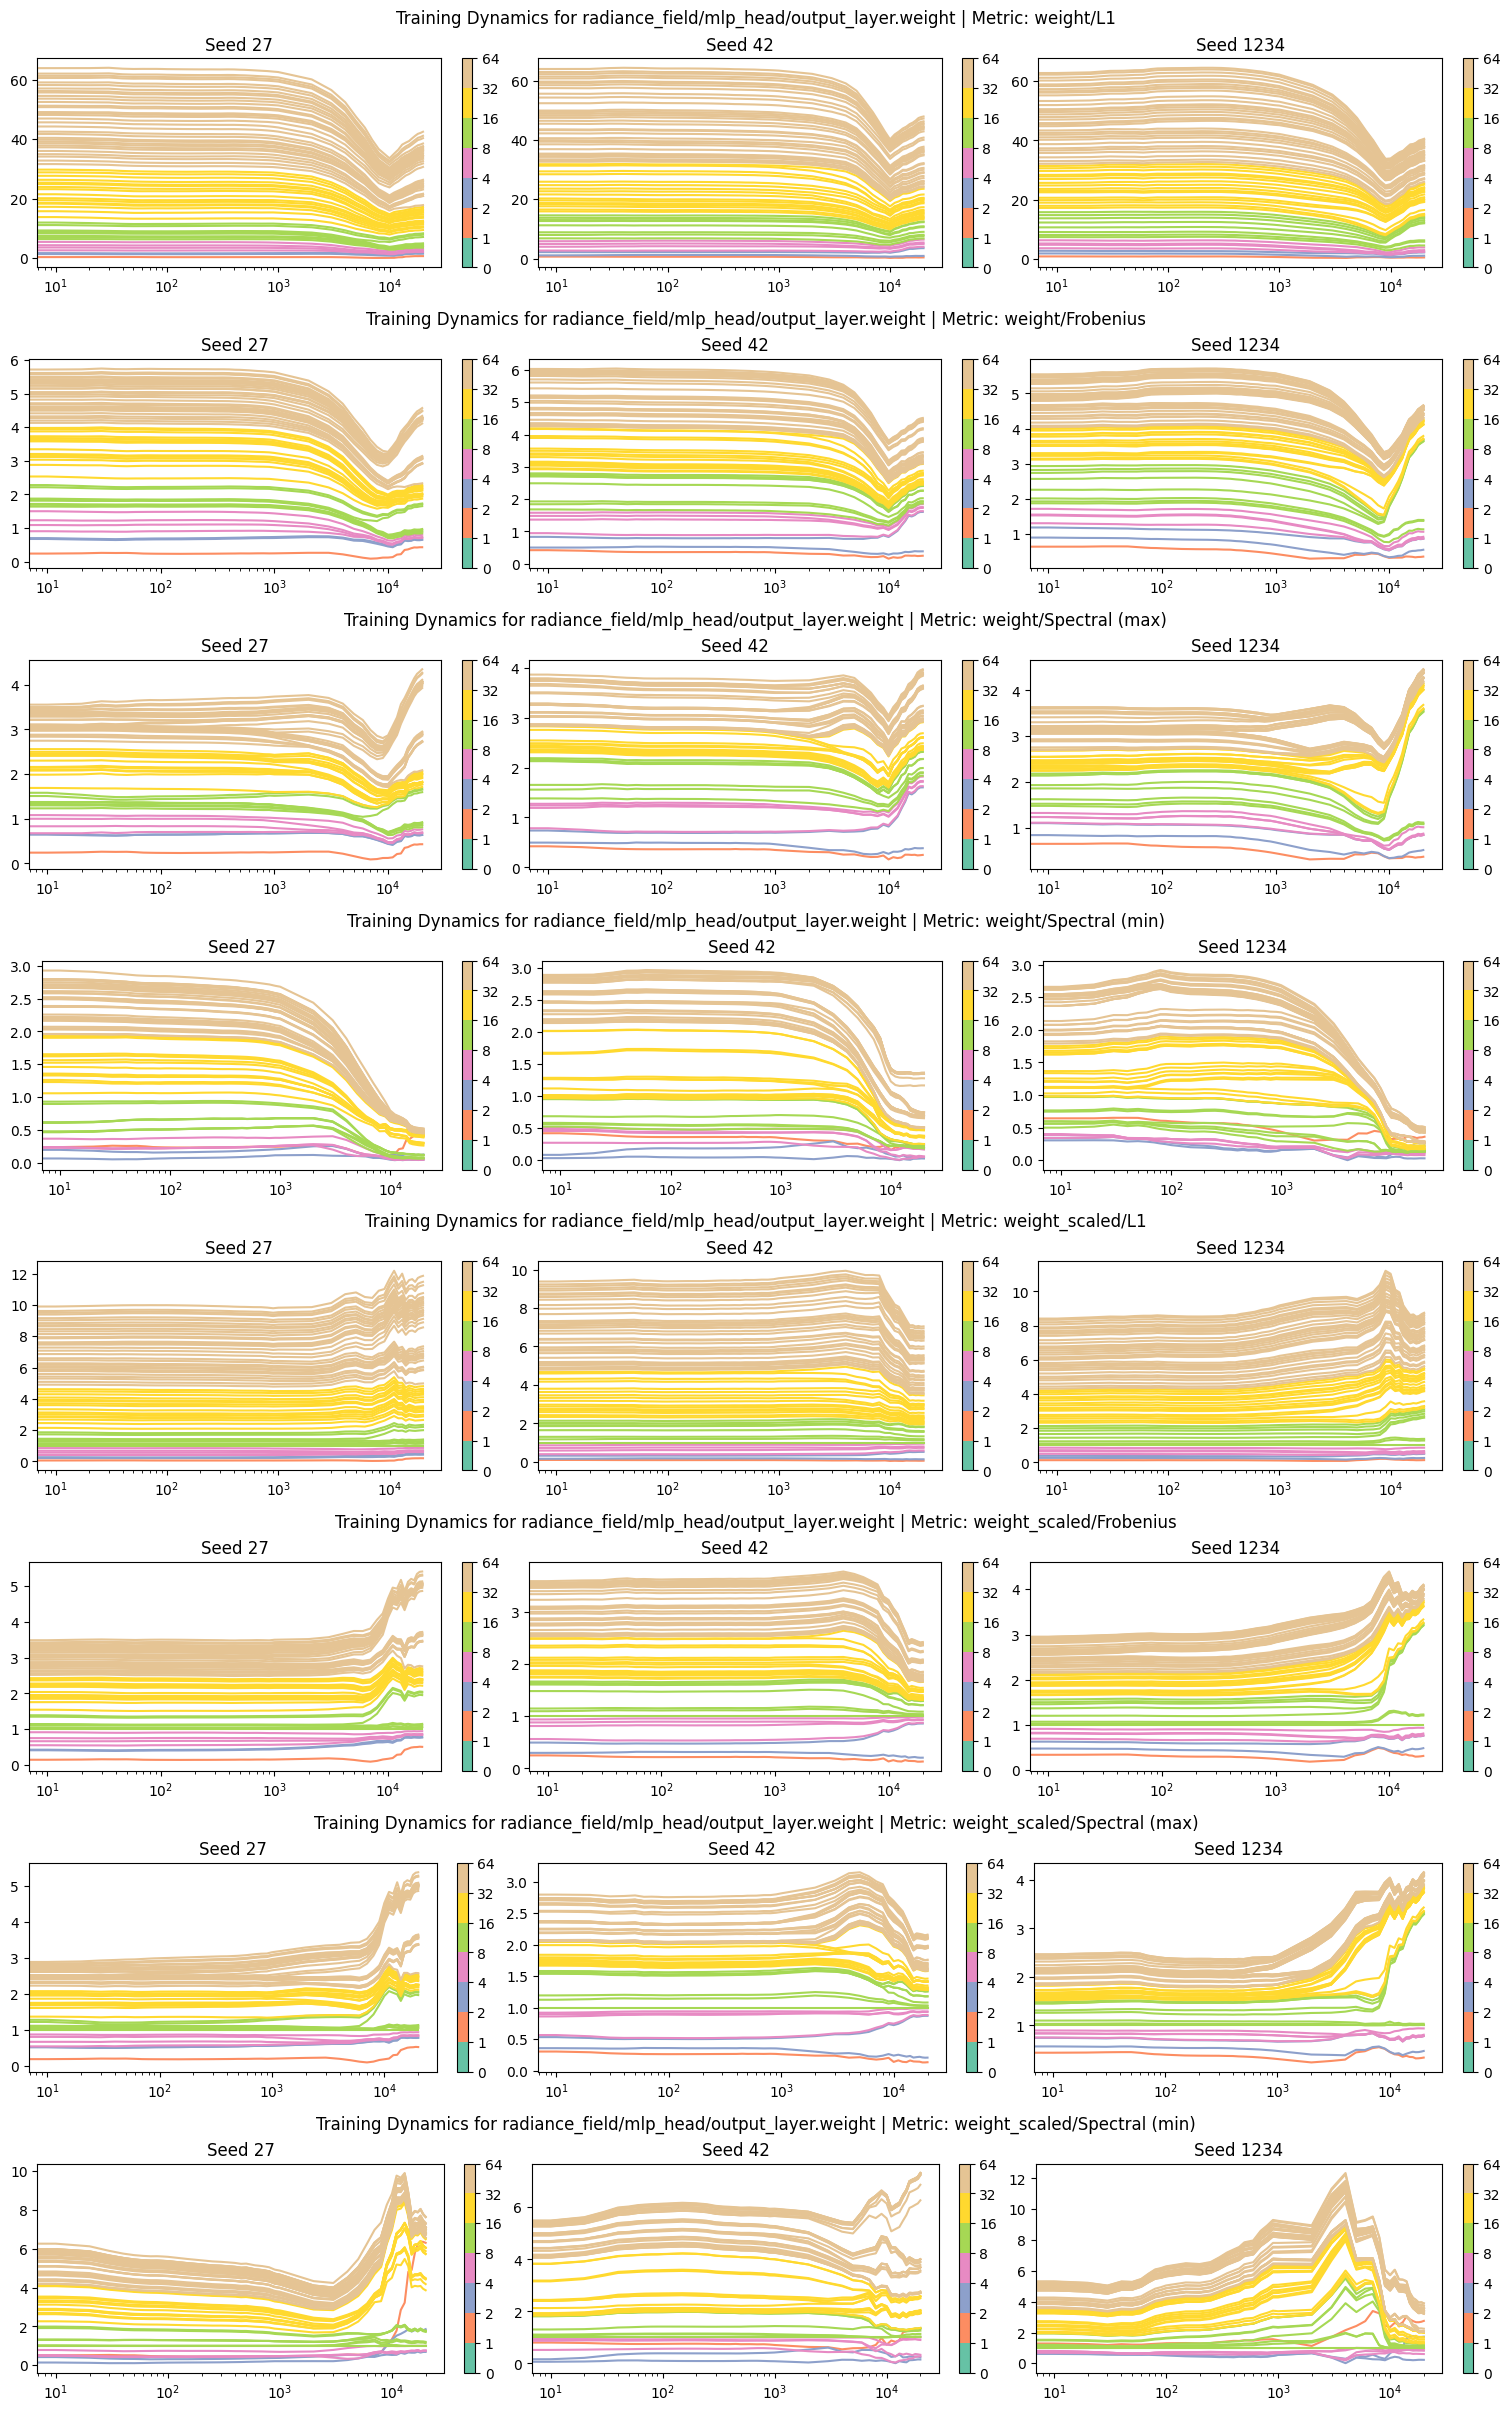

In [8]:
cc = ColorConfig()
metric_types = [
    "weight/L1",
    "weight/Frobenius",
    "weight/Spectral (max)",
    "weight/Spectral (min)",
    "weight_scaled/L1",
    "weight_scaled/Frobenius",
    "weight_scaled/Spectral (max)",
    "weight_scaled/Spectral (min)",
]
fig = plt.figure(layout="constrained", figsize=(15, 3 * len(metric_types)))
subfigs = fig.subfigures(len(metric_types), 1, wspace=0.07)
for i, metric_type in enumerate(metric_types):
    subfig = subfigs[i]
    subfig.suptitle(f"Training Dynamics for {module} | Metric: {metric_type}")
    subplots = subfig.subplots(1, len(module_group["seed"].unique()))
    for j, (seed, seed_group) in enumerate(module_group.groupby(by="seed")):
        ax = subplots[j]
        for width, width_group in seed_group.groupby(by="width"):
            color = cc.get_color(width)
            ax.plot(width_group["step"], width_group[f"{metric_type}"], color=color)
        ax.set_xscale("log")
        ax.set_title(f"Seed {seed}")
        cc.get_colorbar(ax)

### Issues
Why is the training dynamics for the proposal_net_0 constant? Is this why we found that the grads were 0? Maybe it's not getting optimized for some reason??

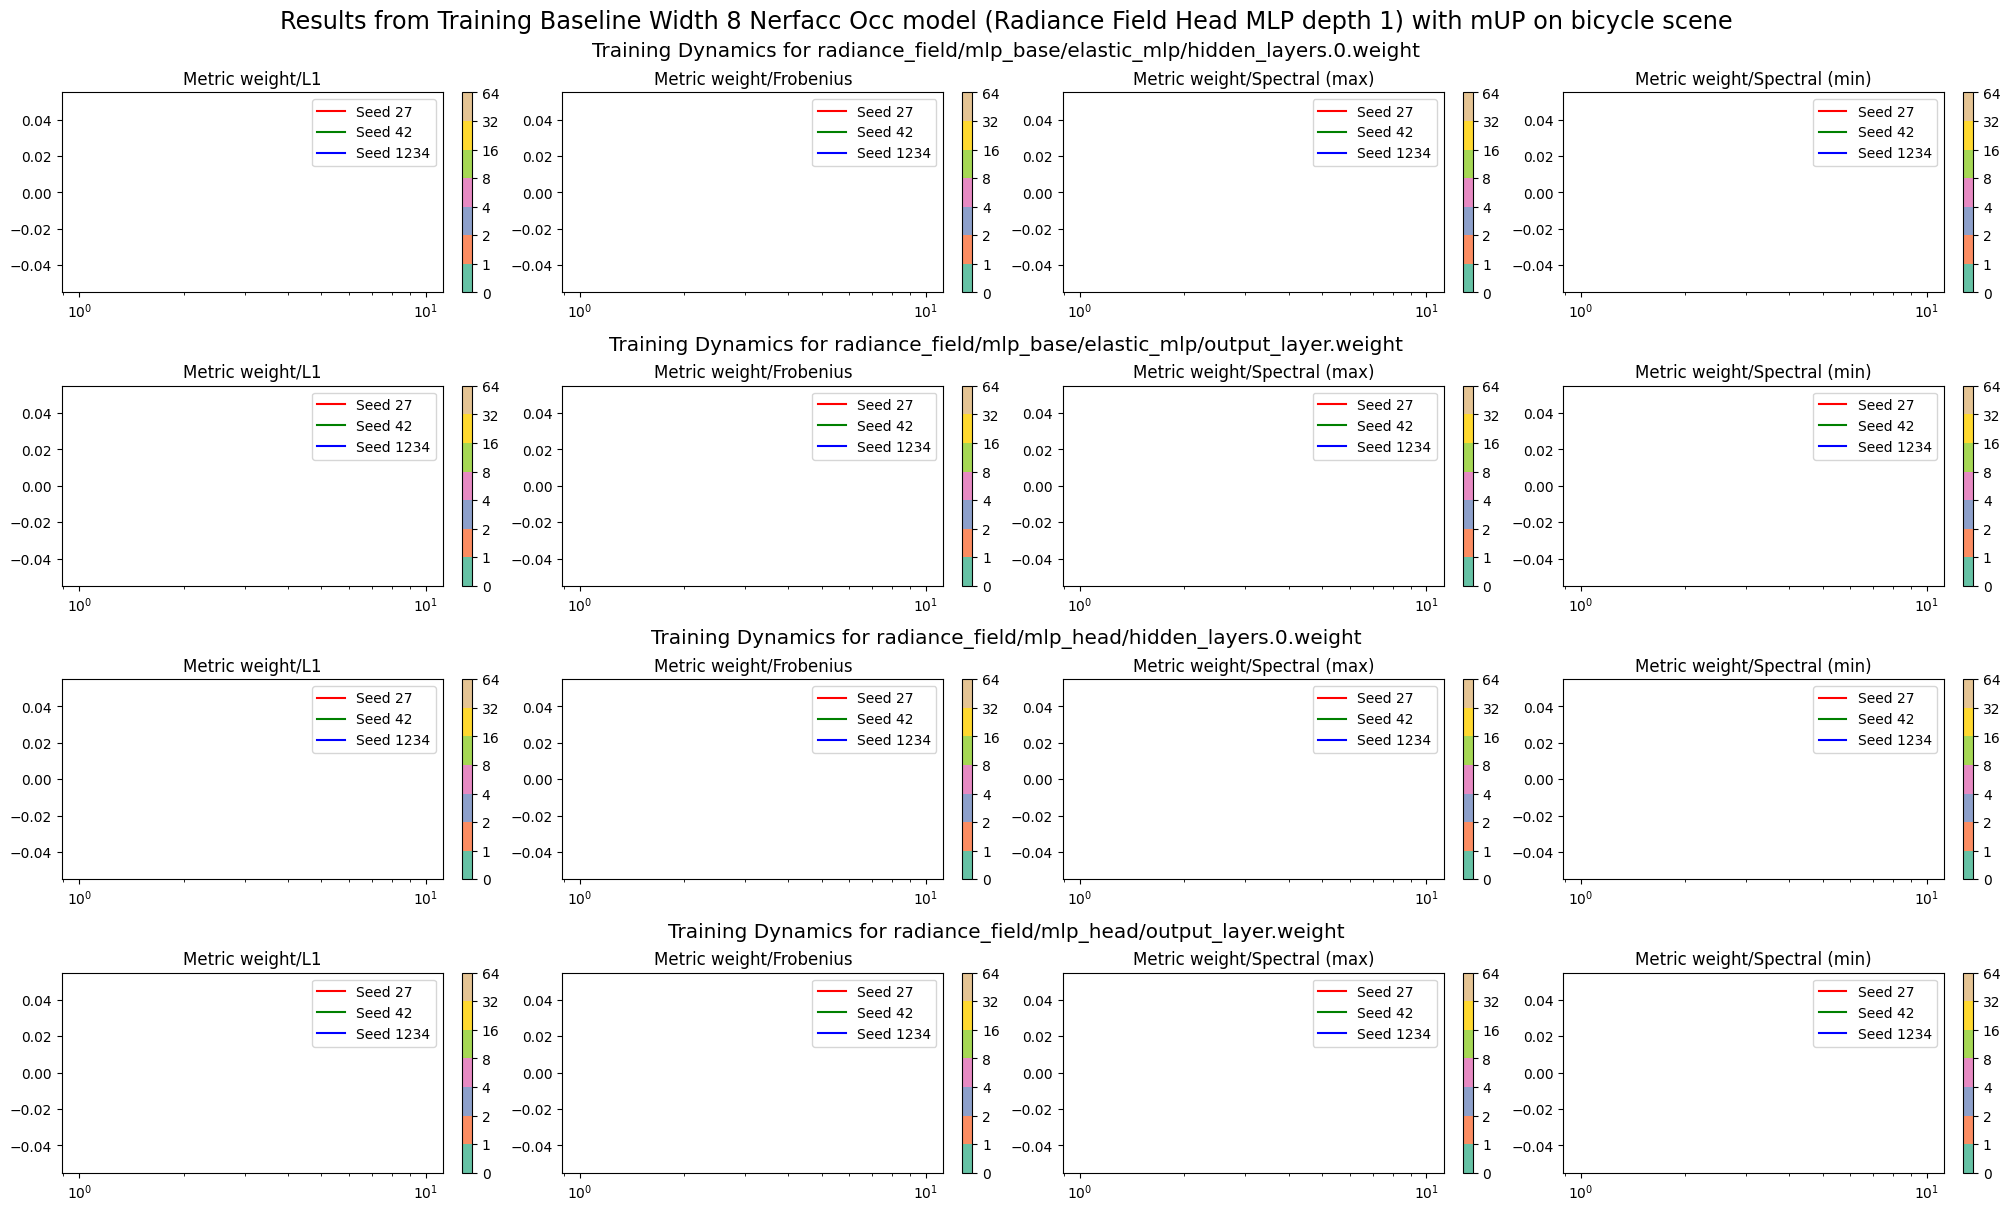

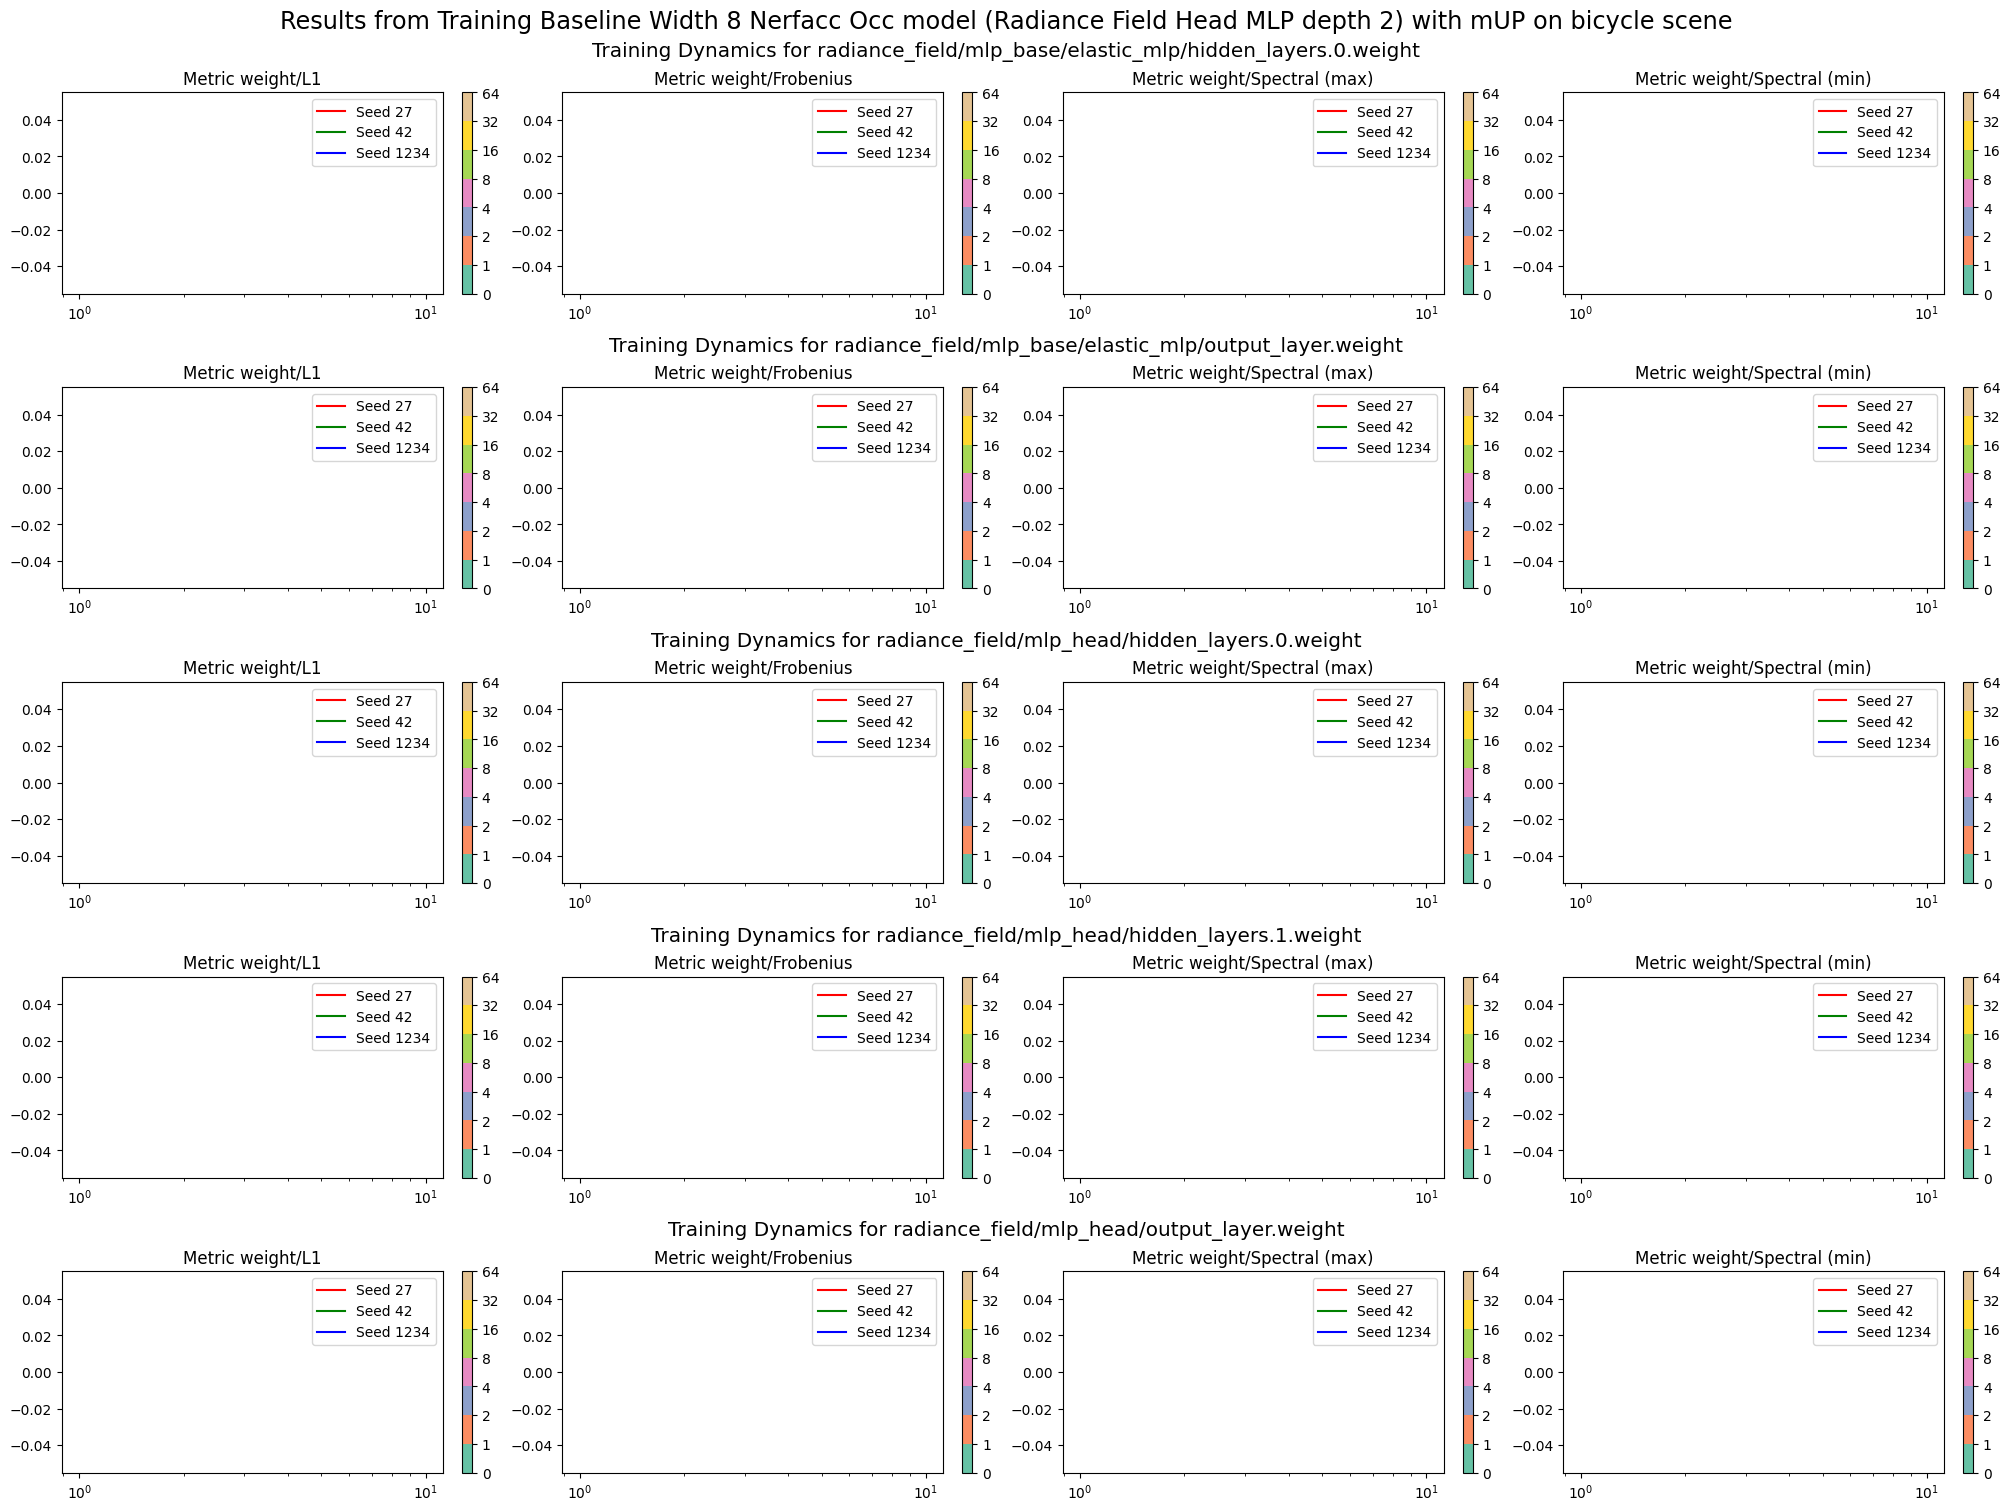

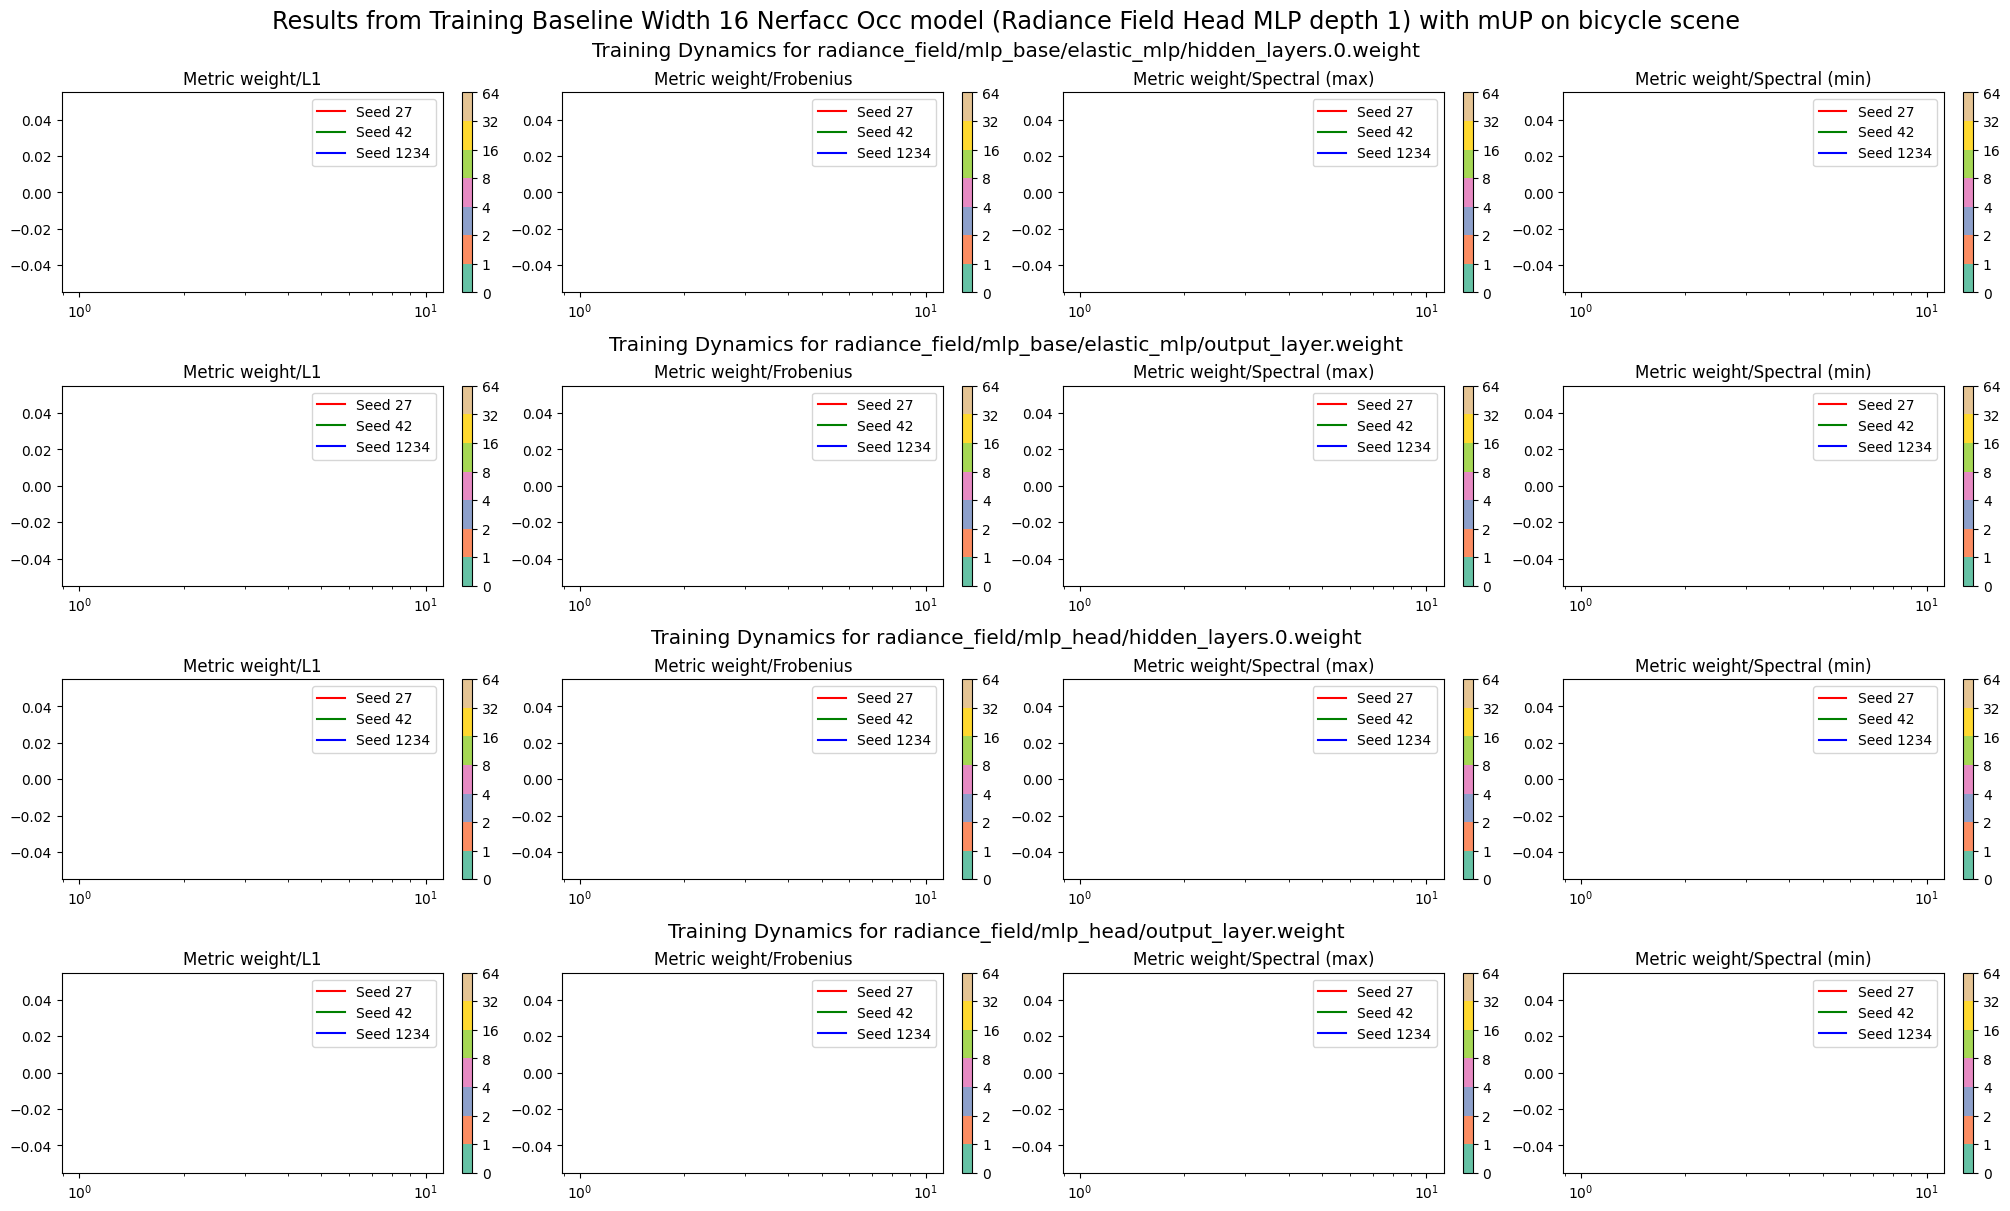

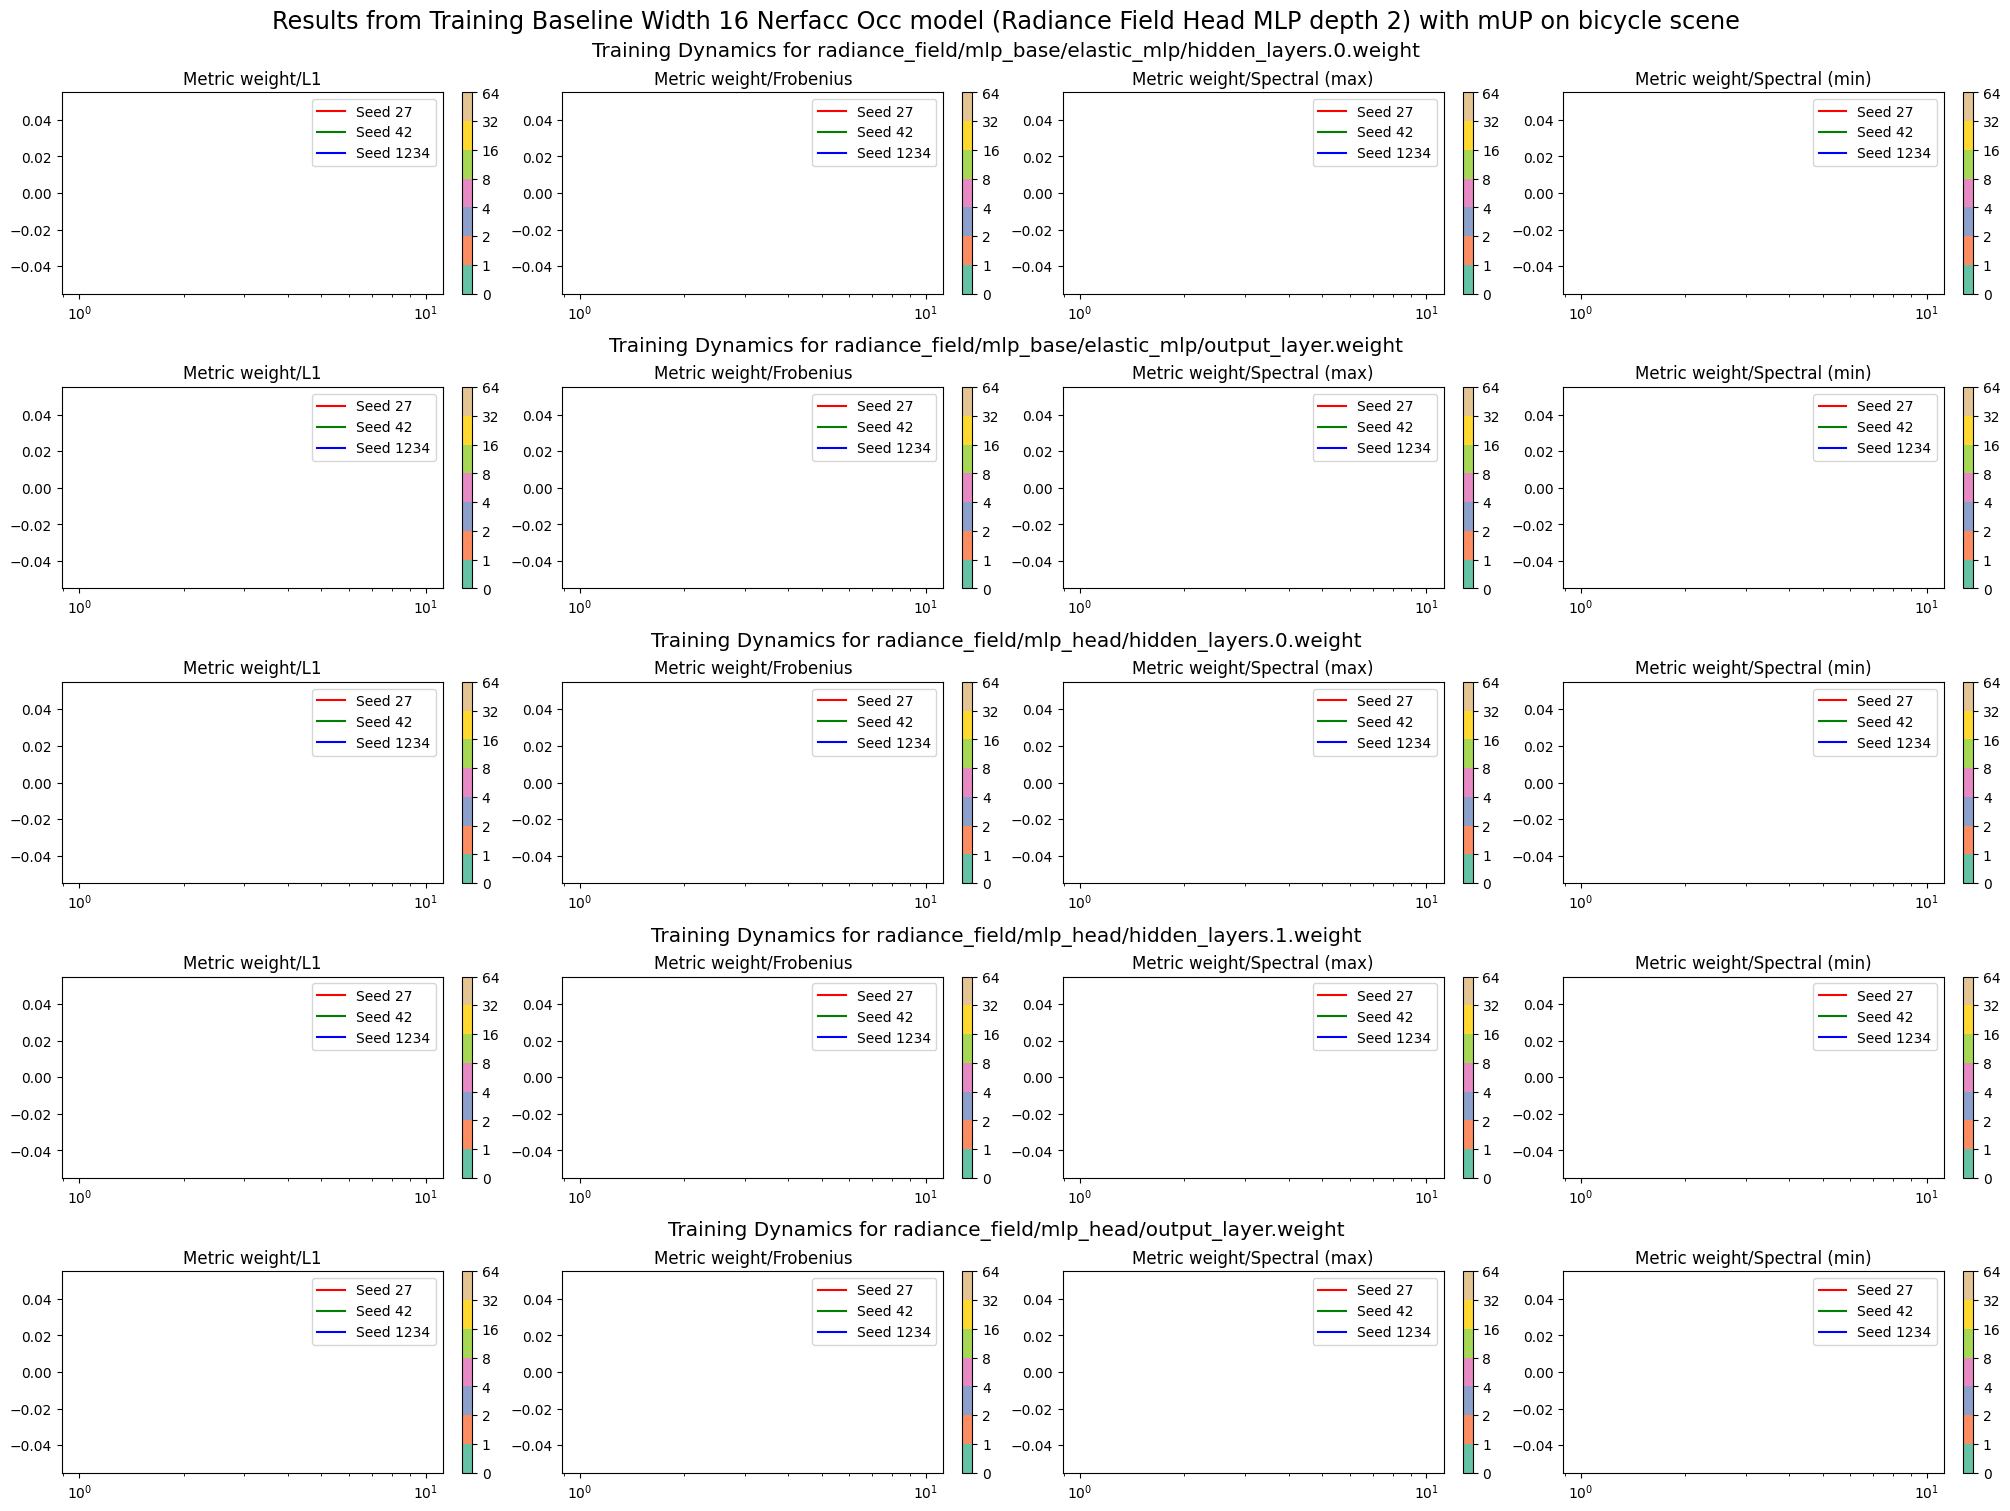

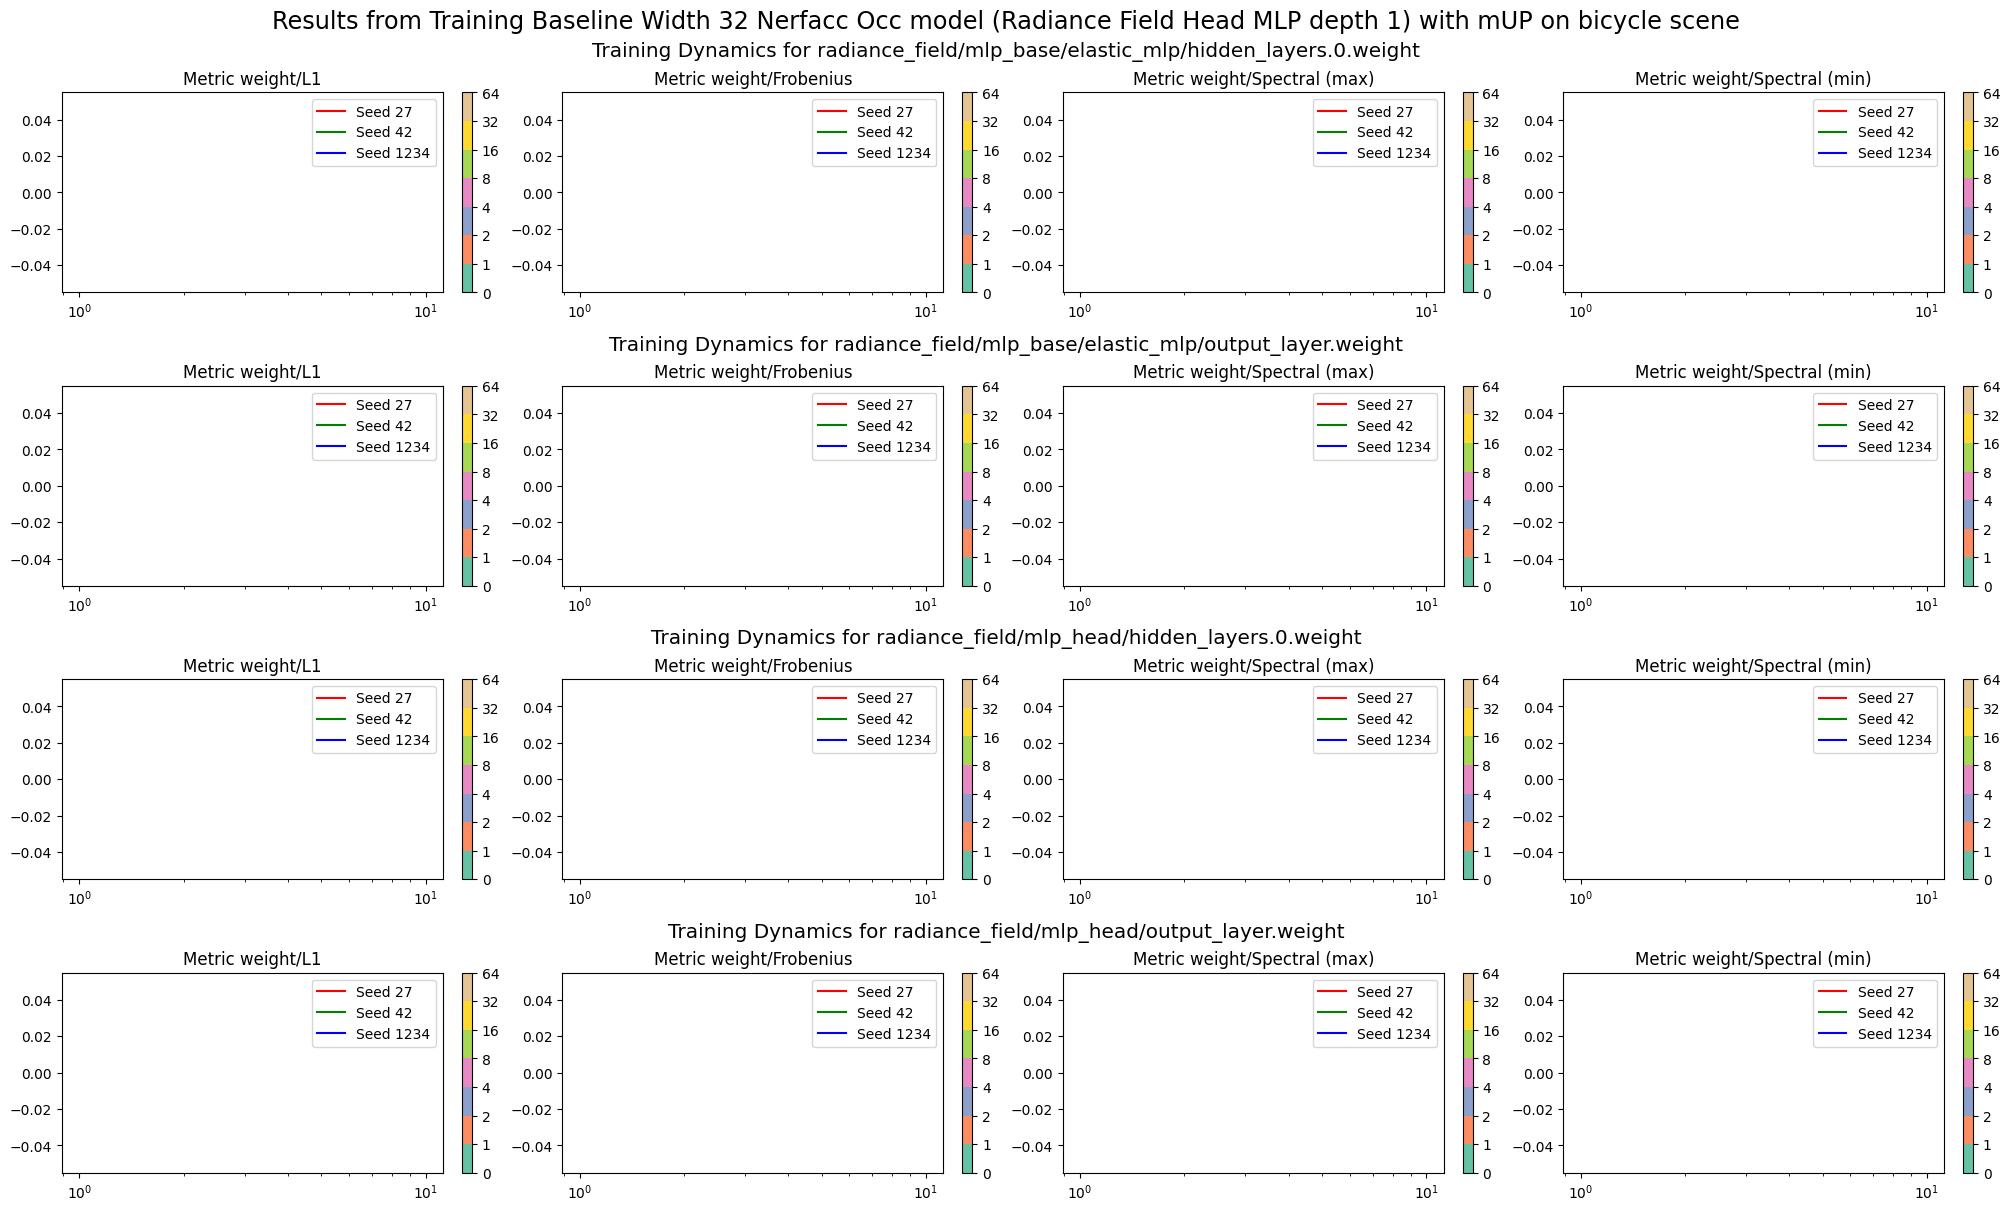

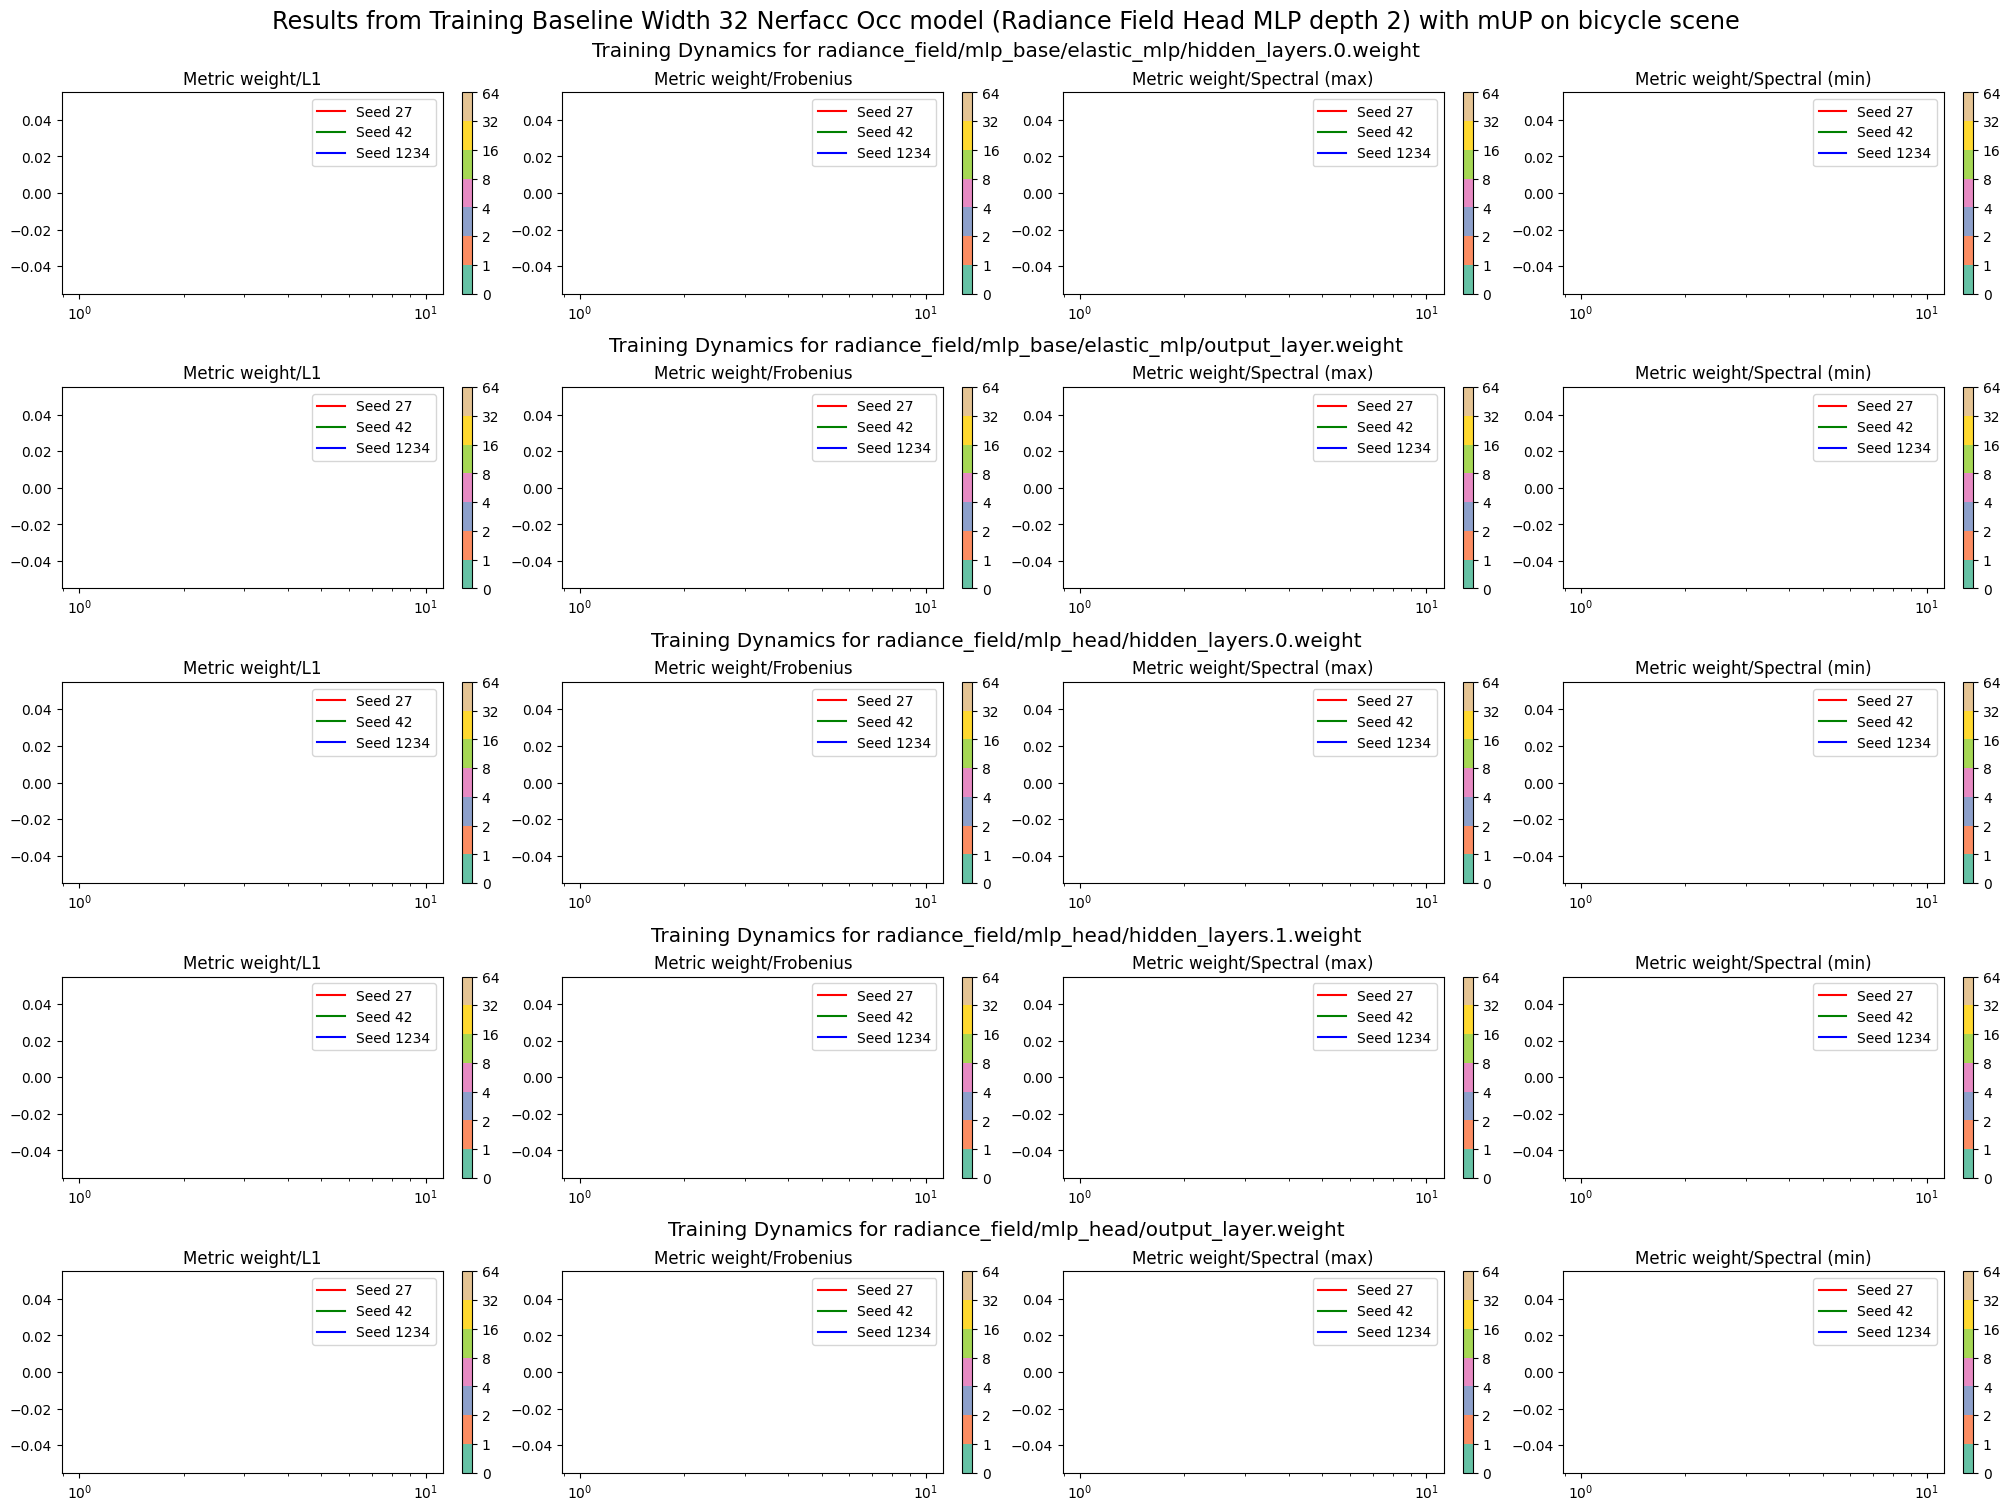

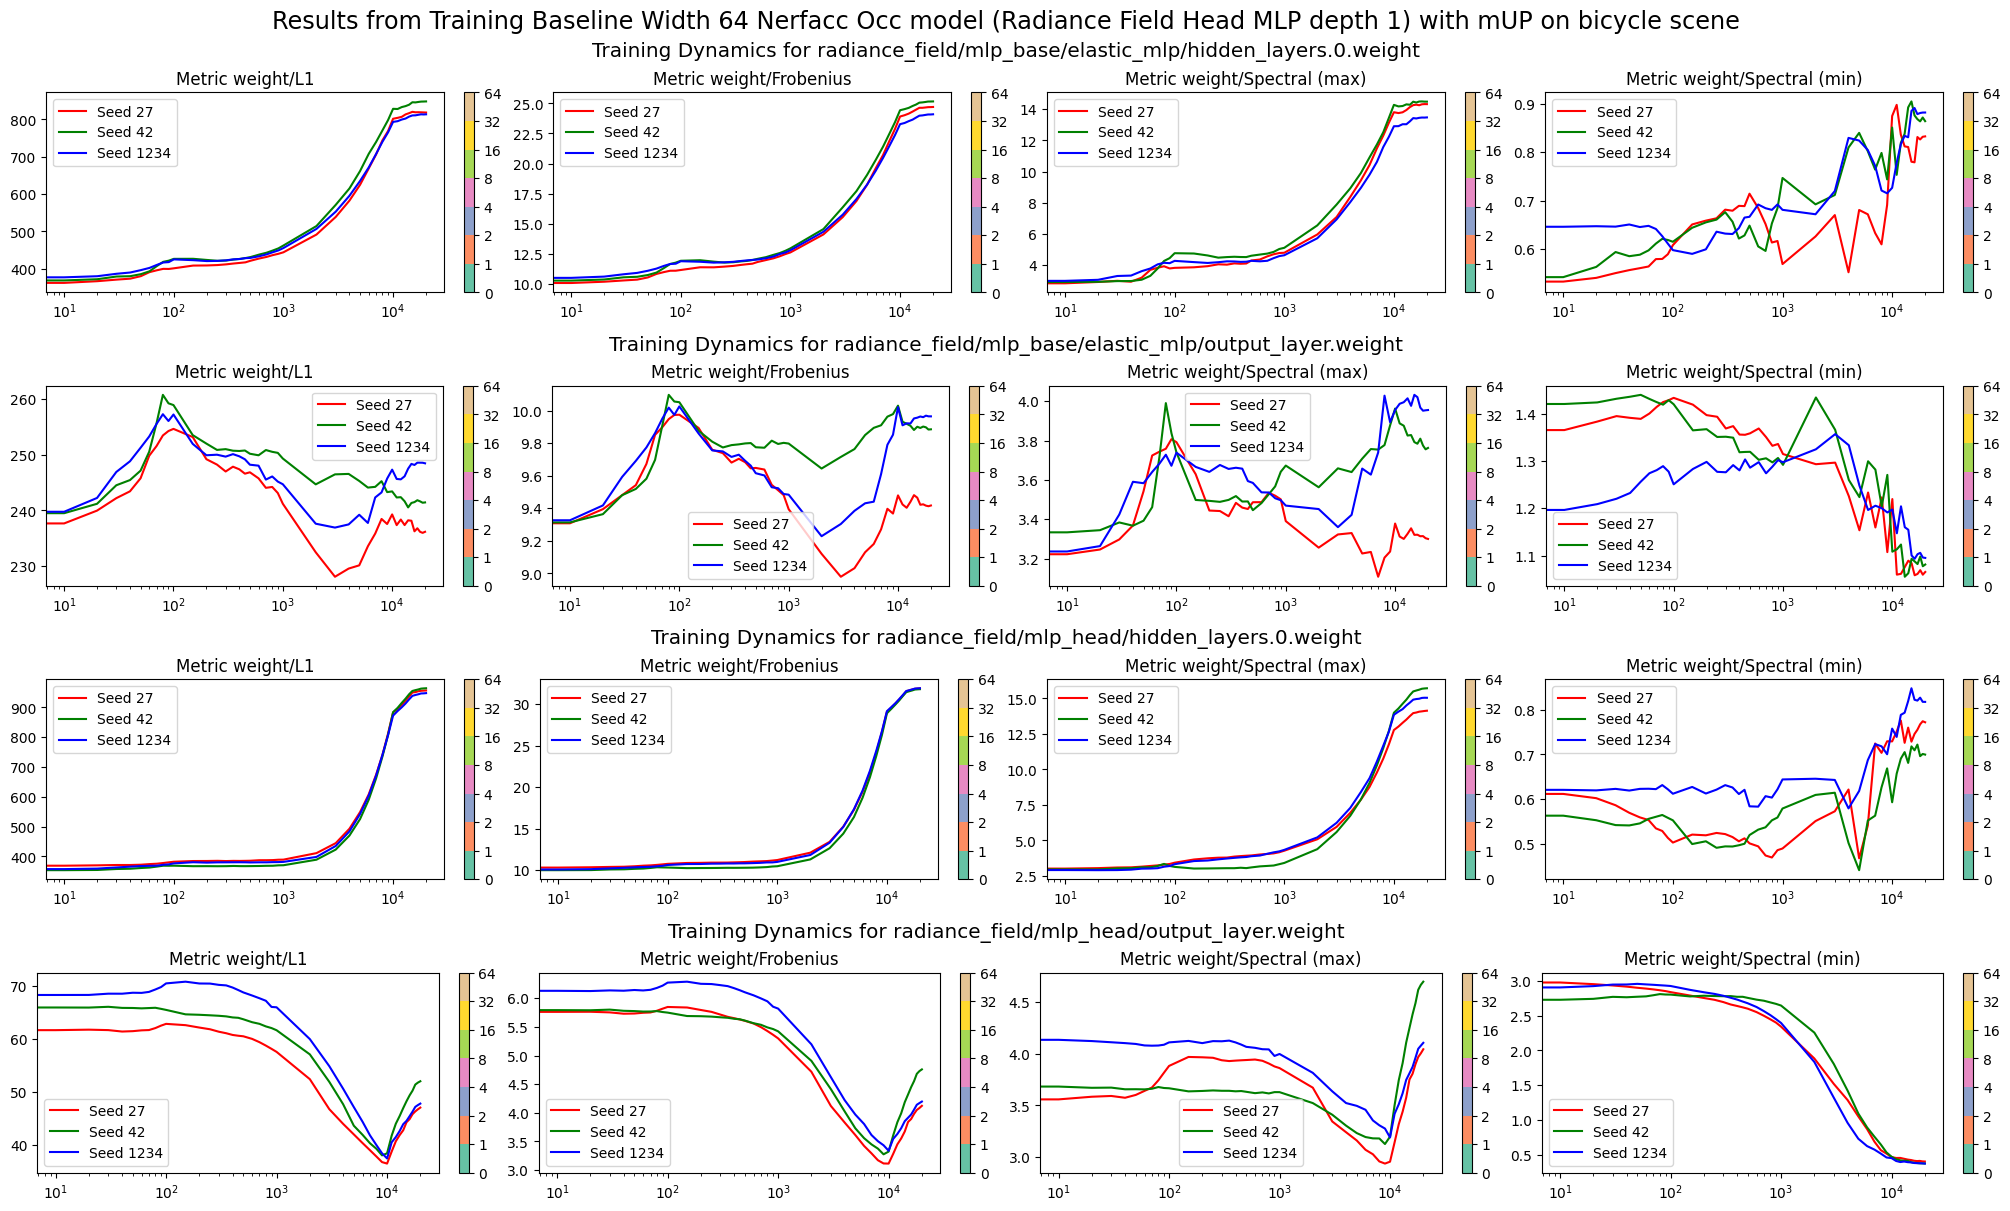

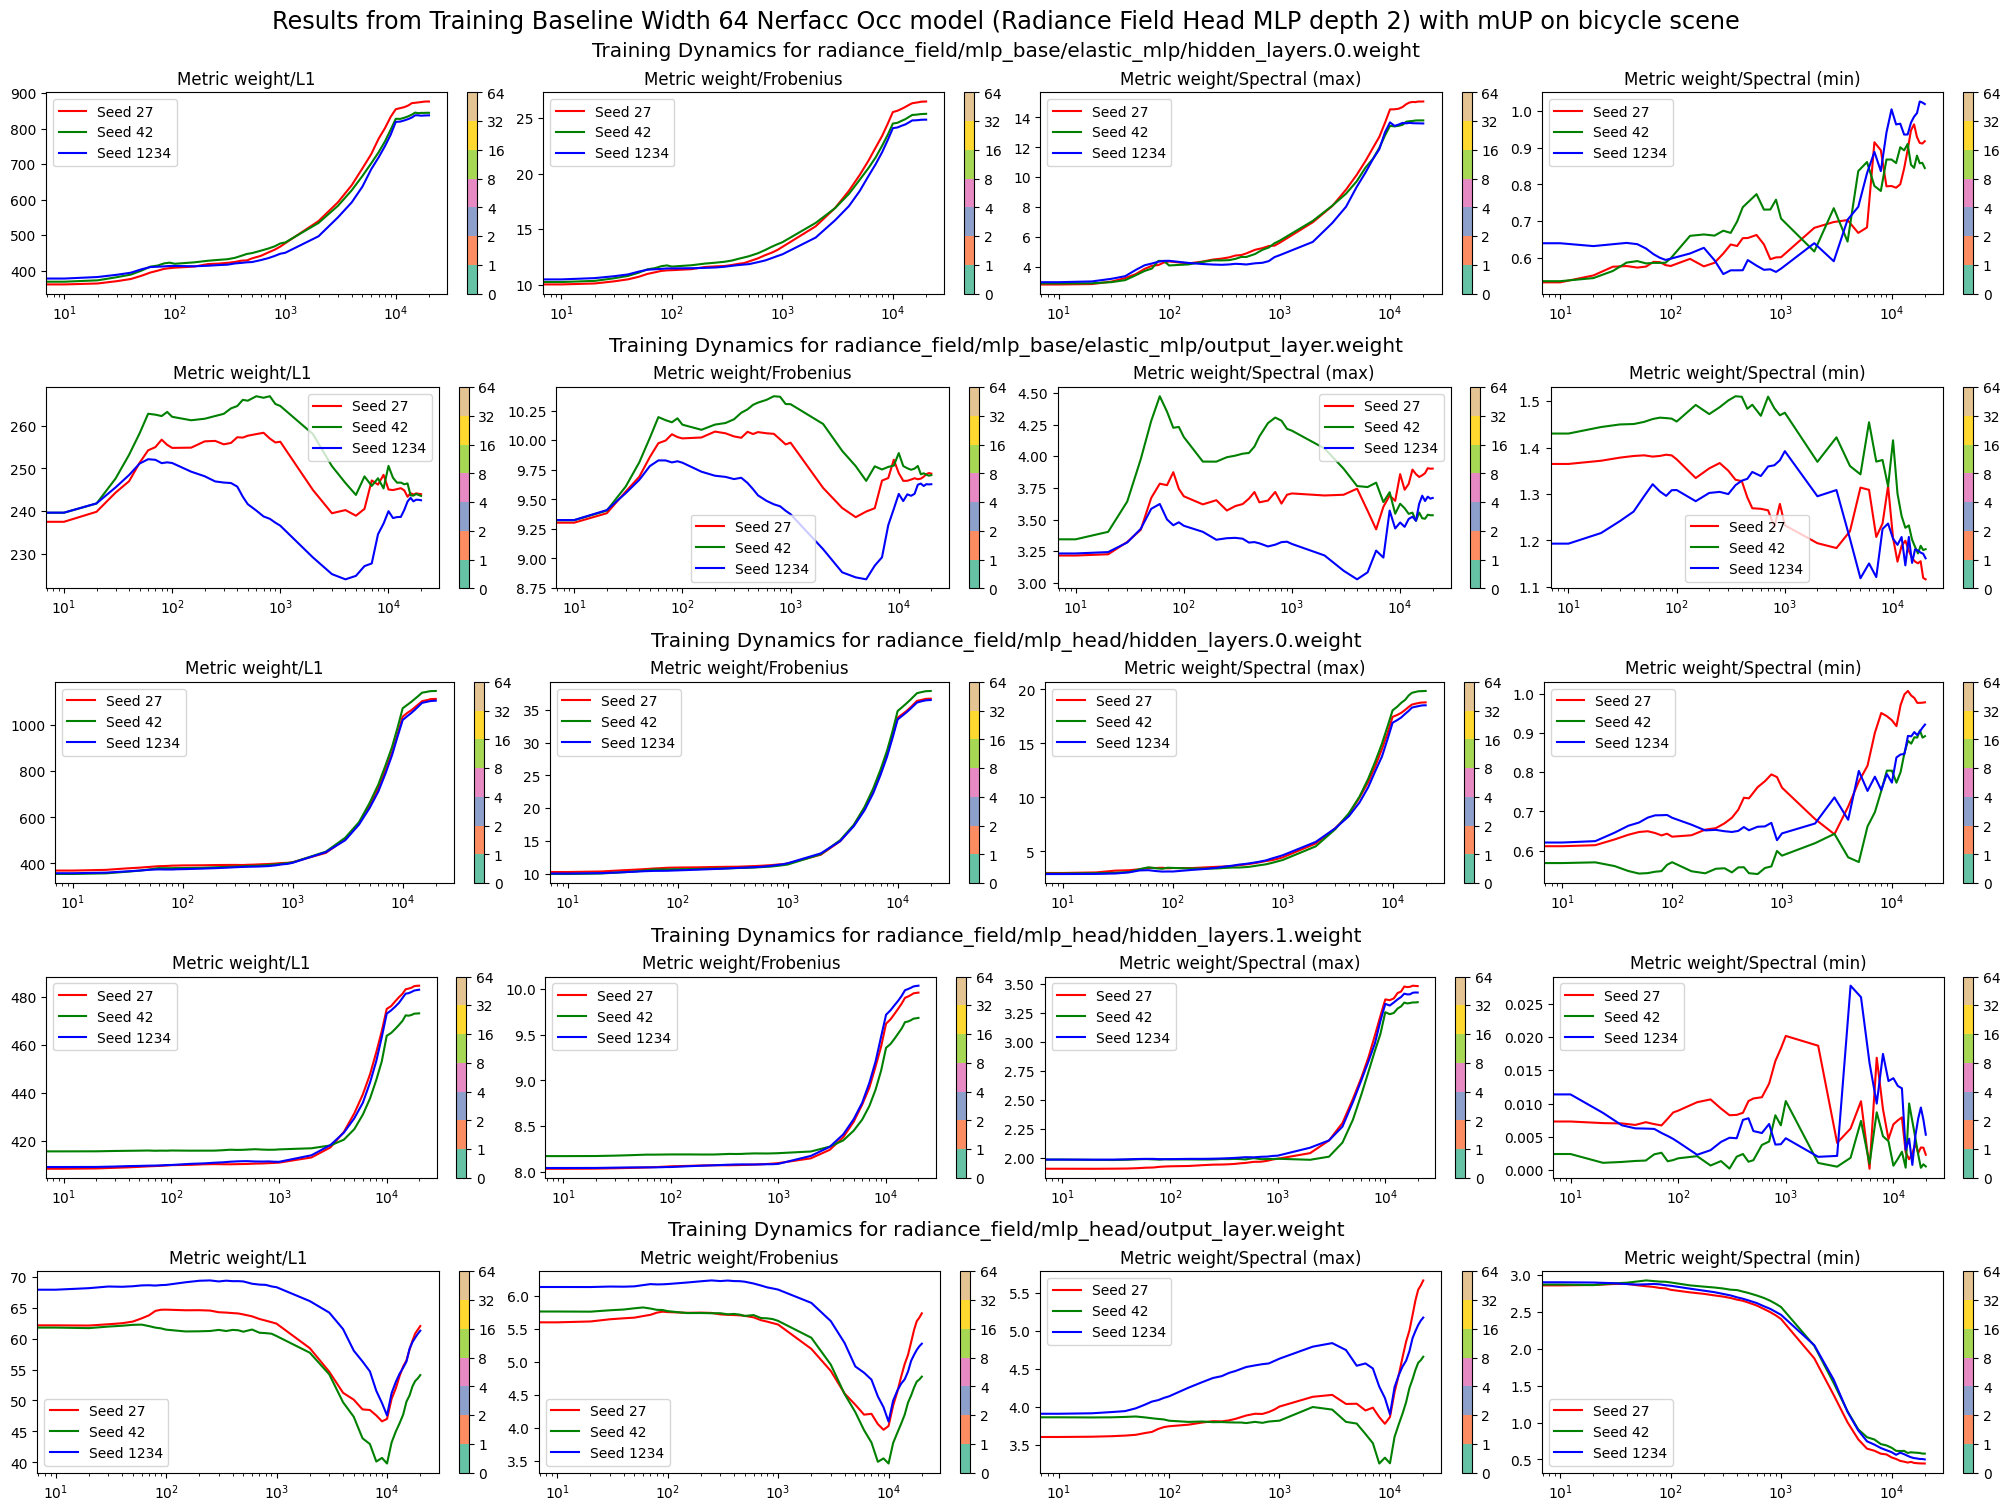

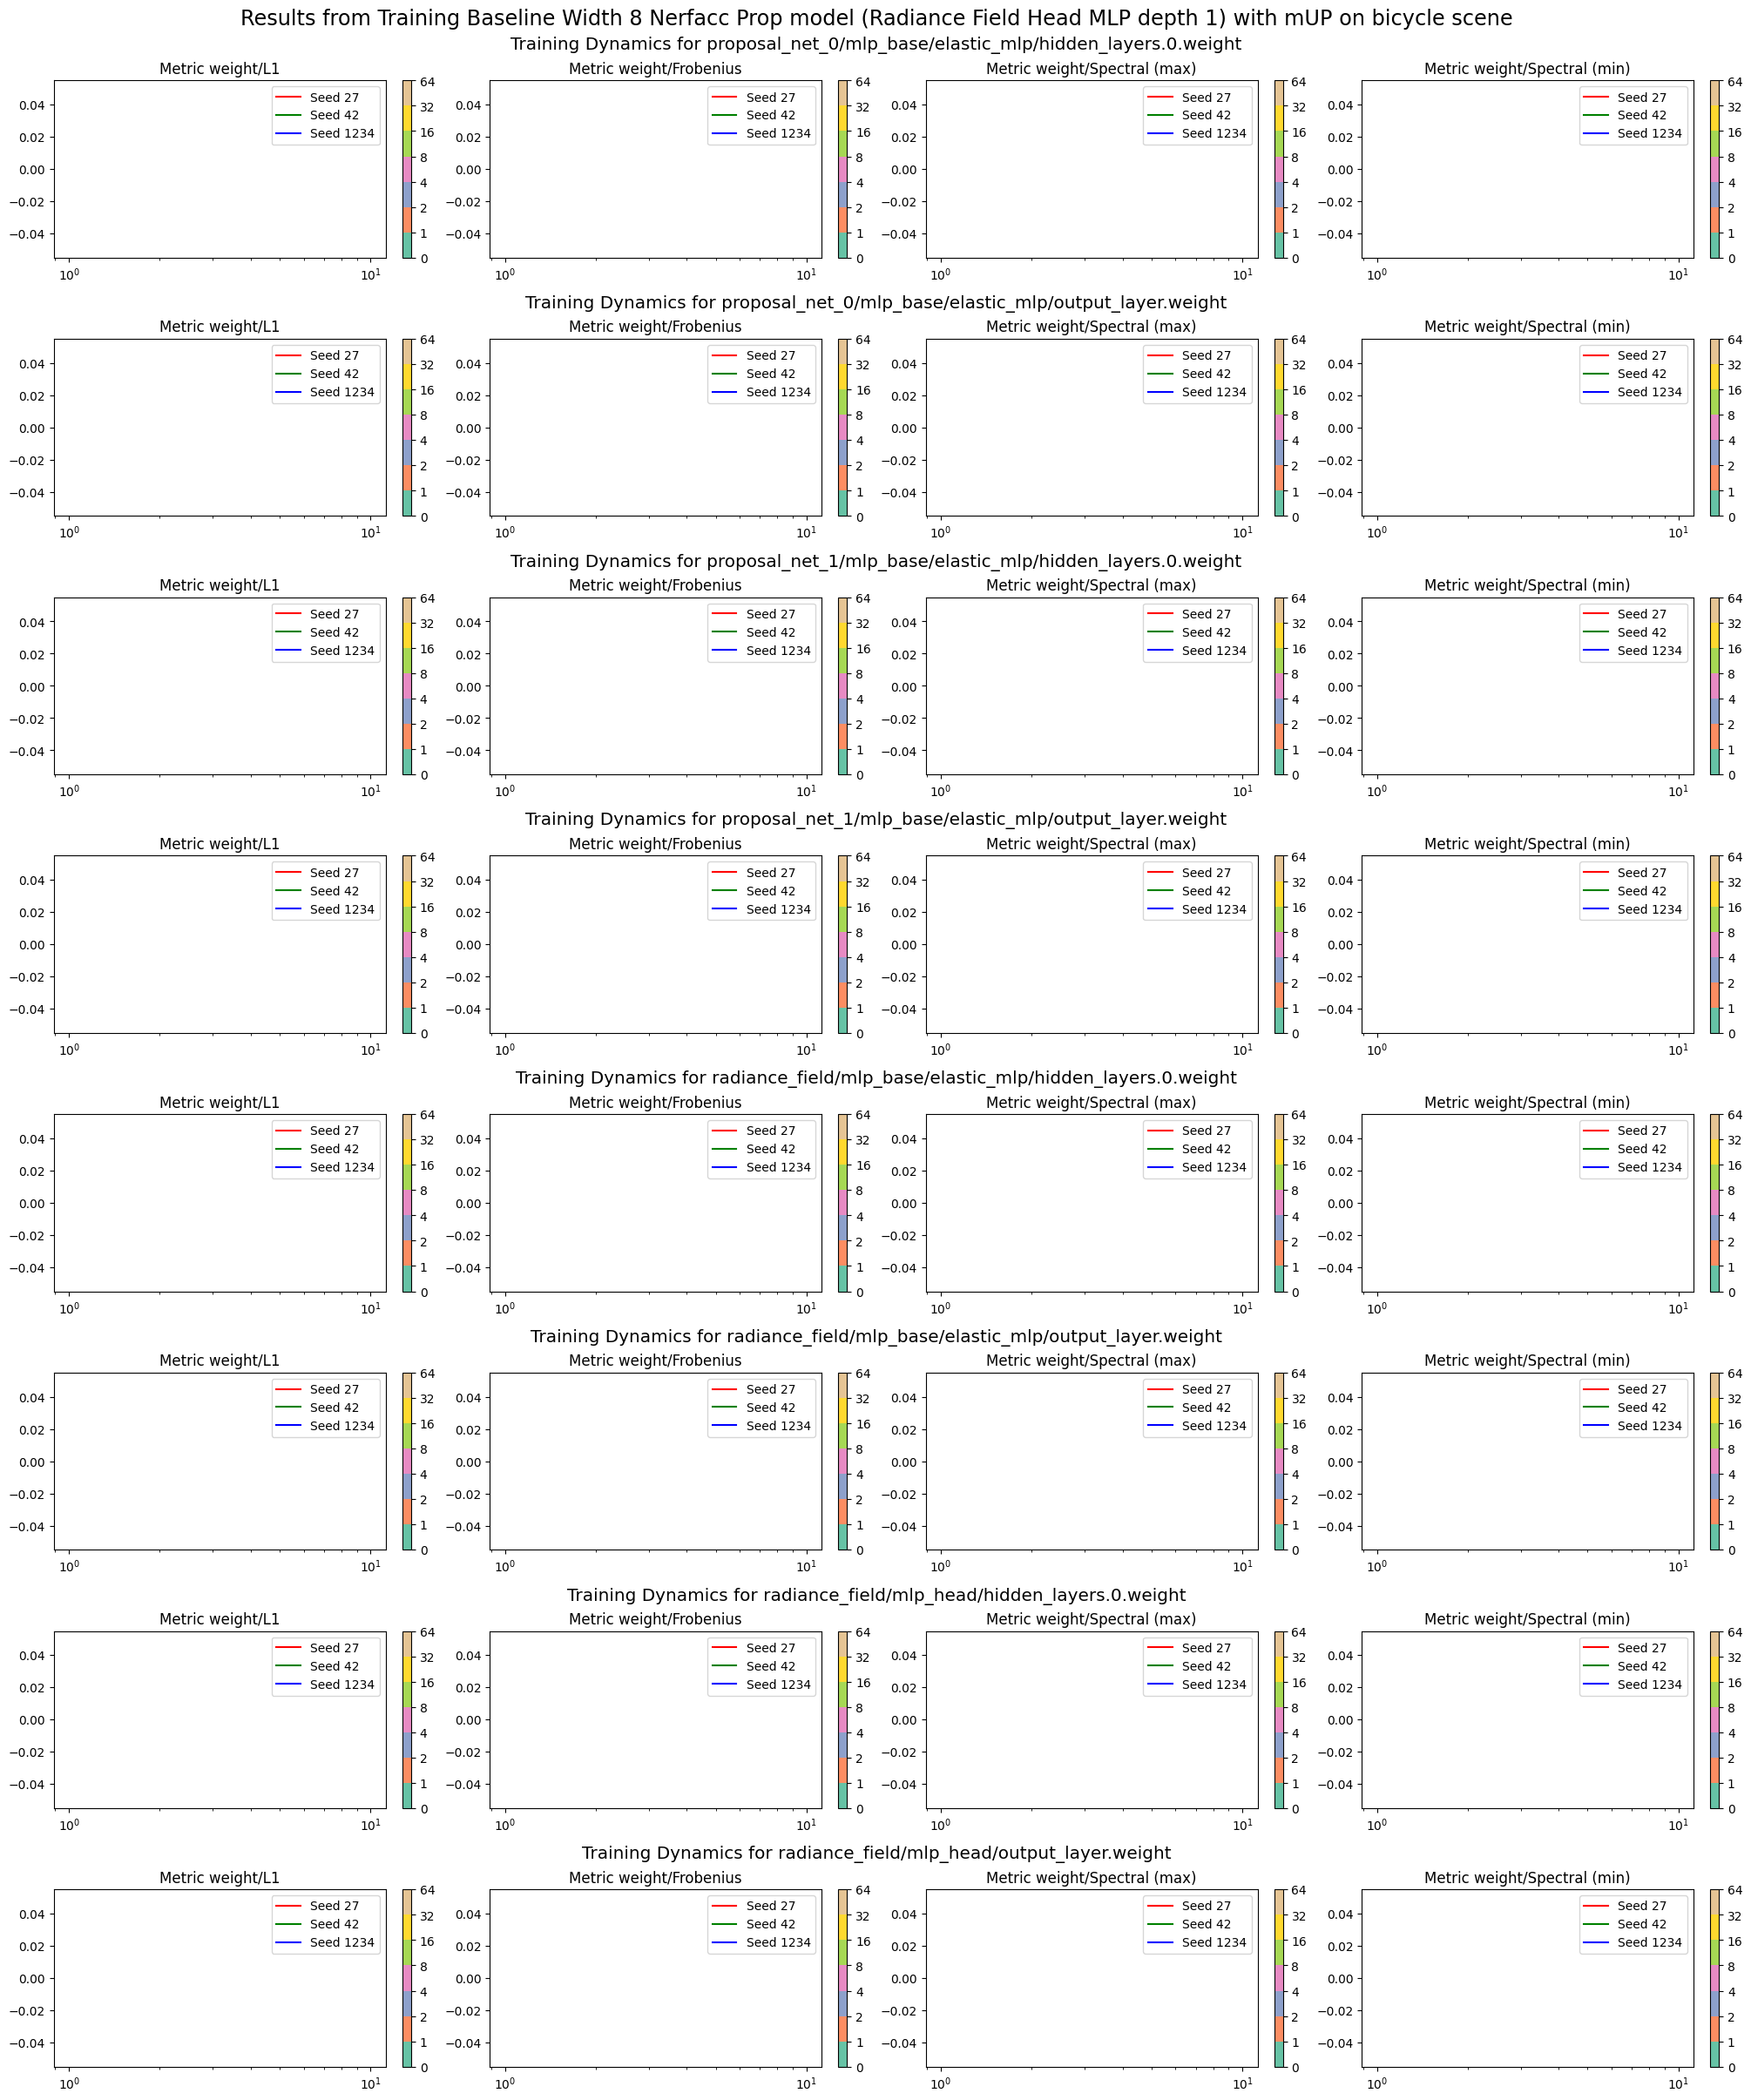

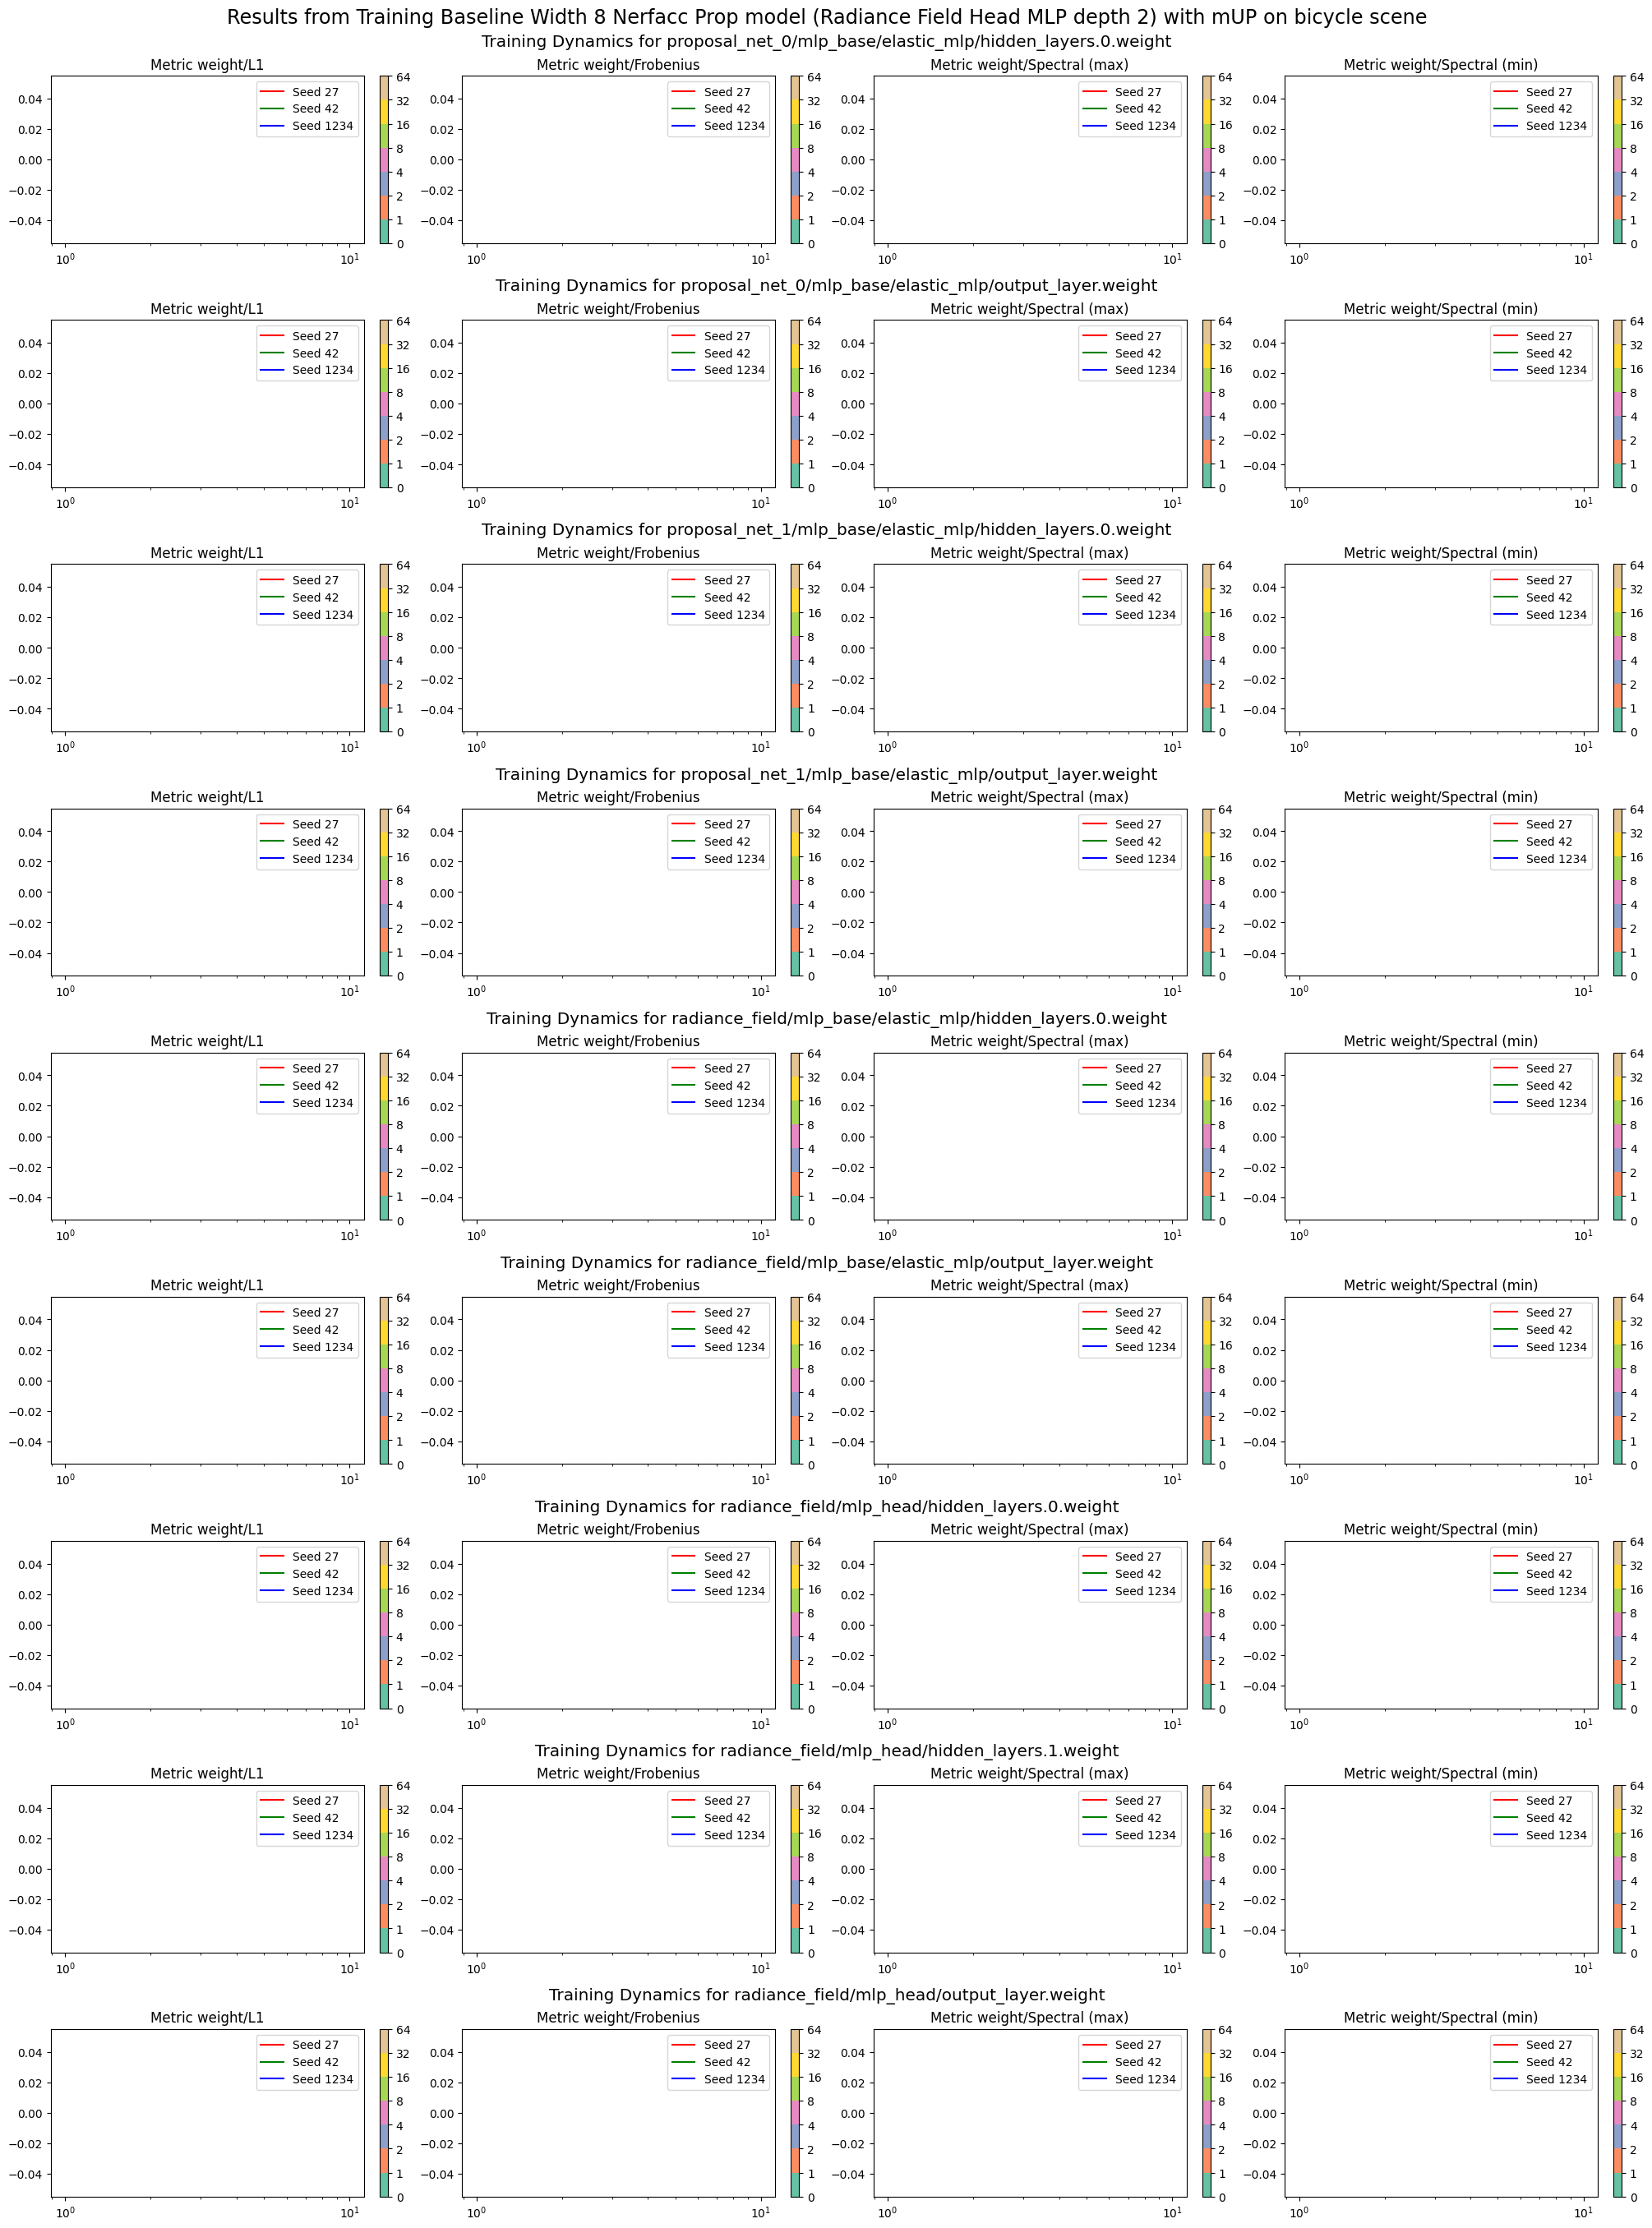

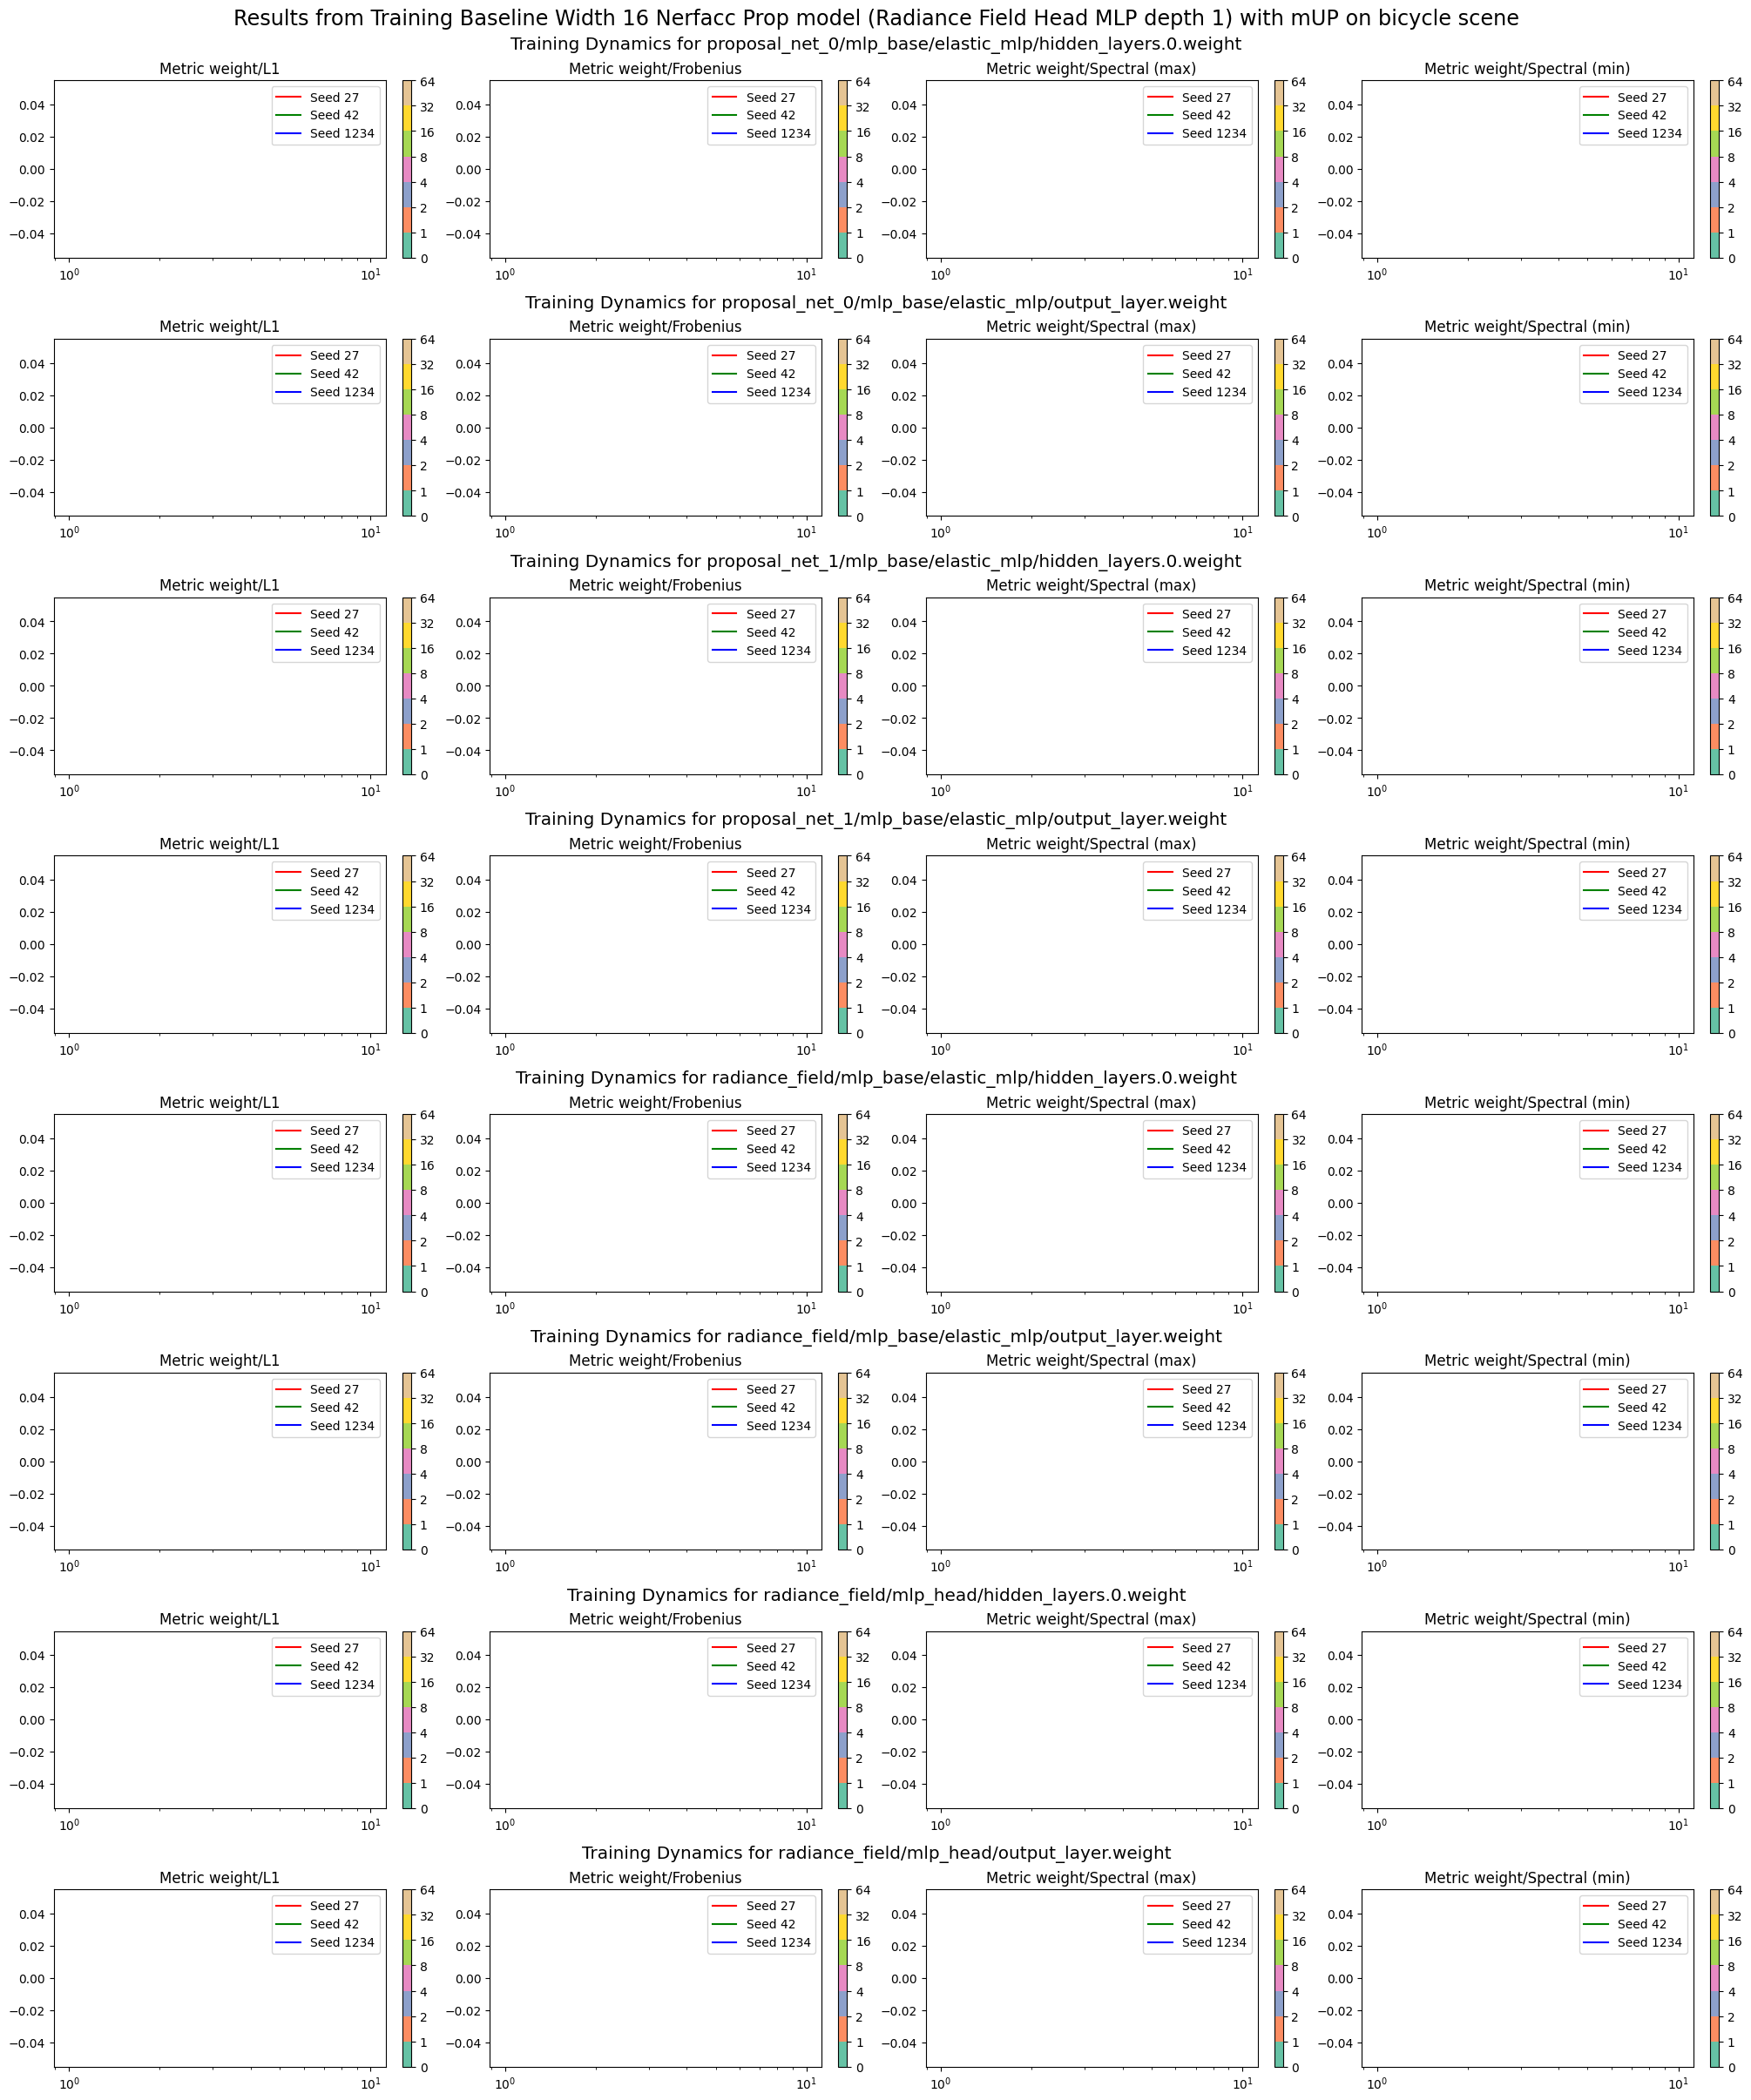

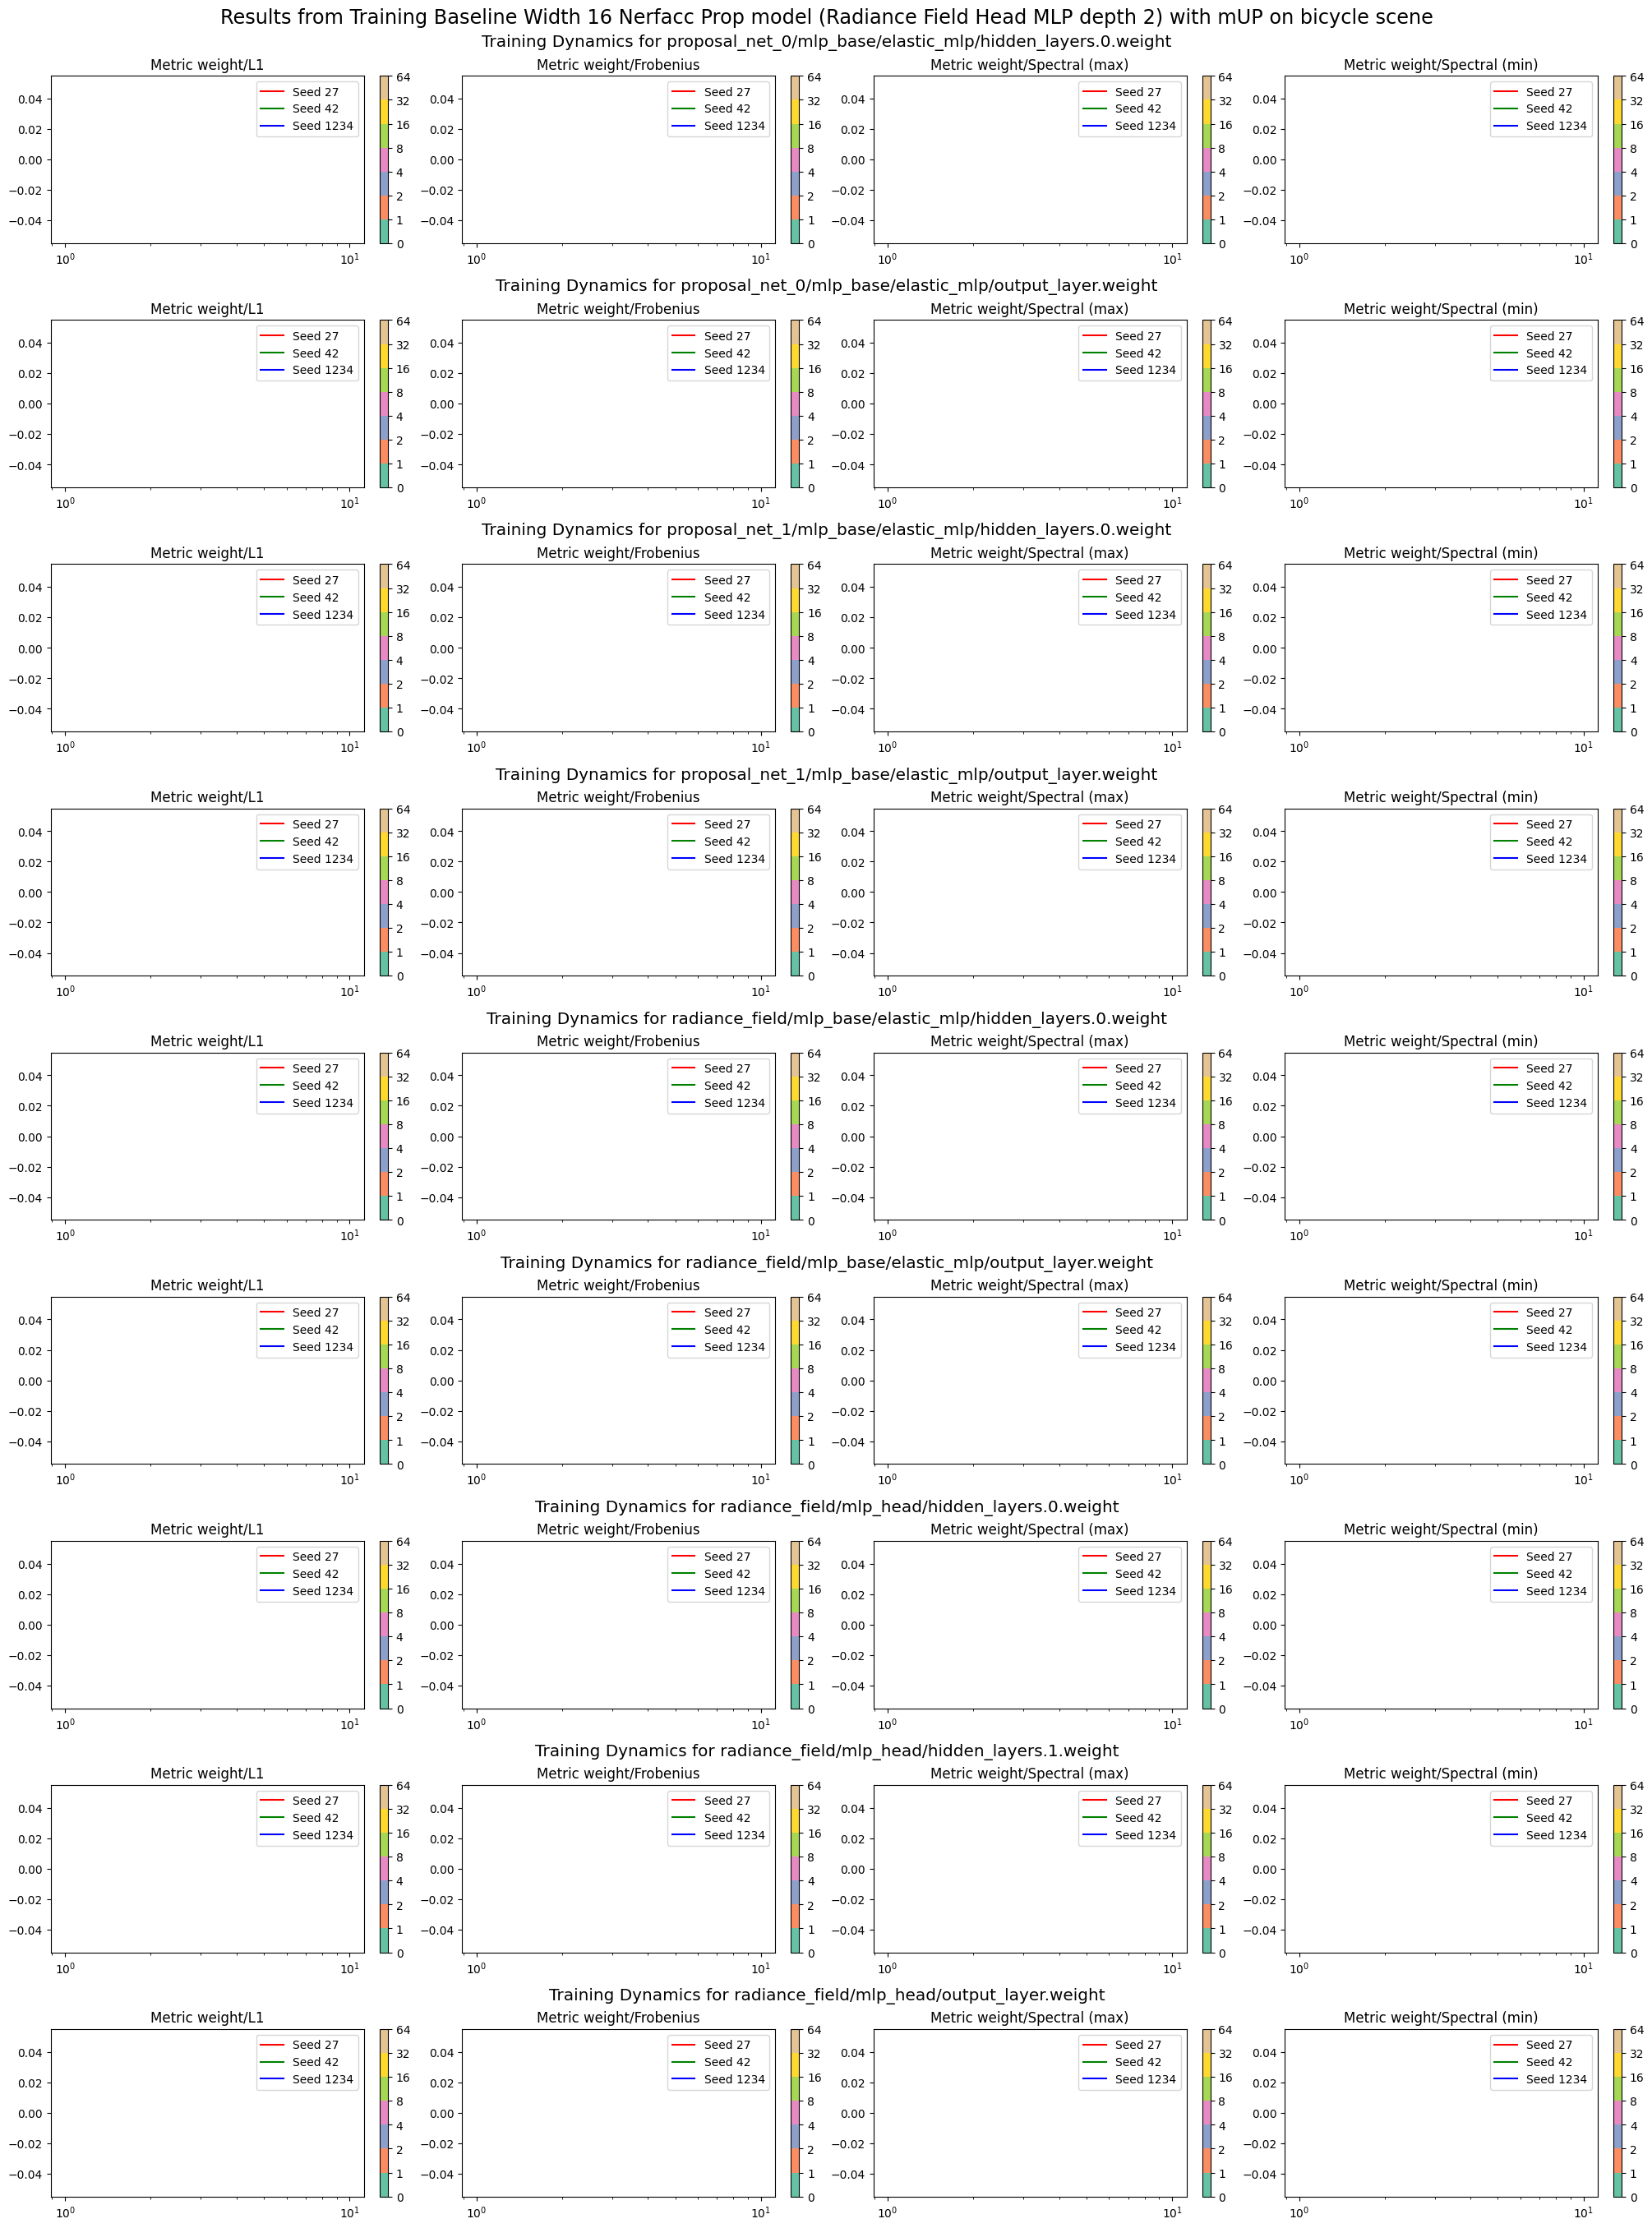

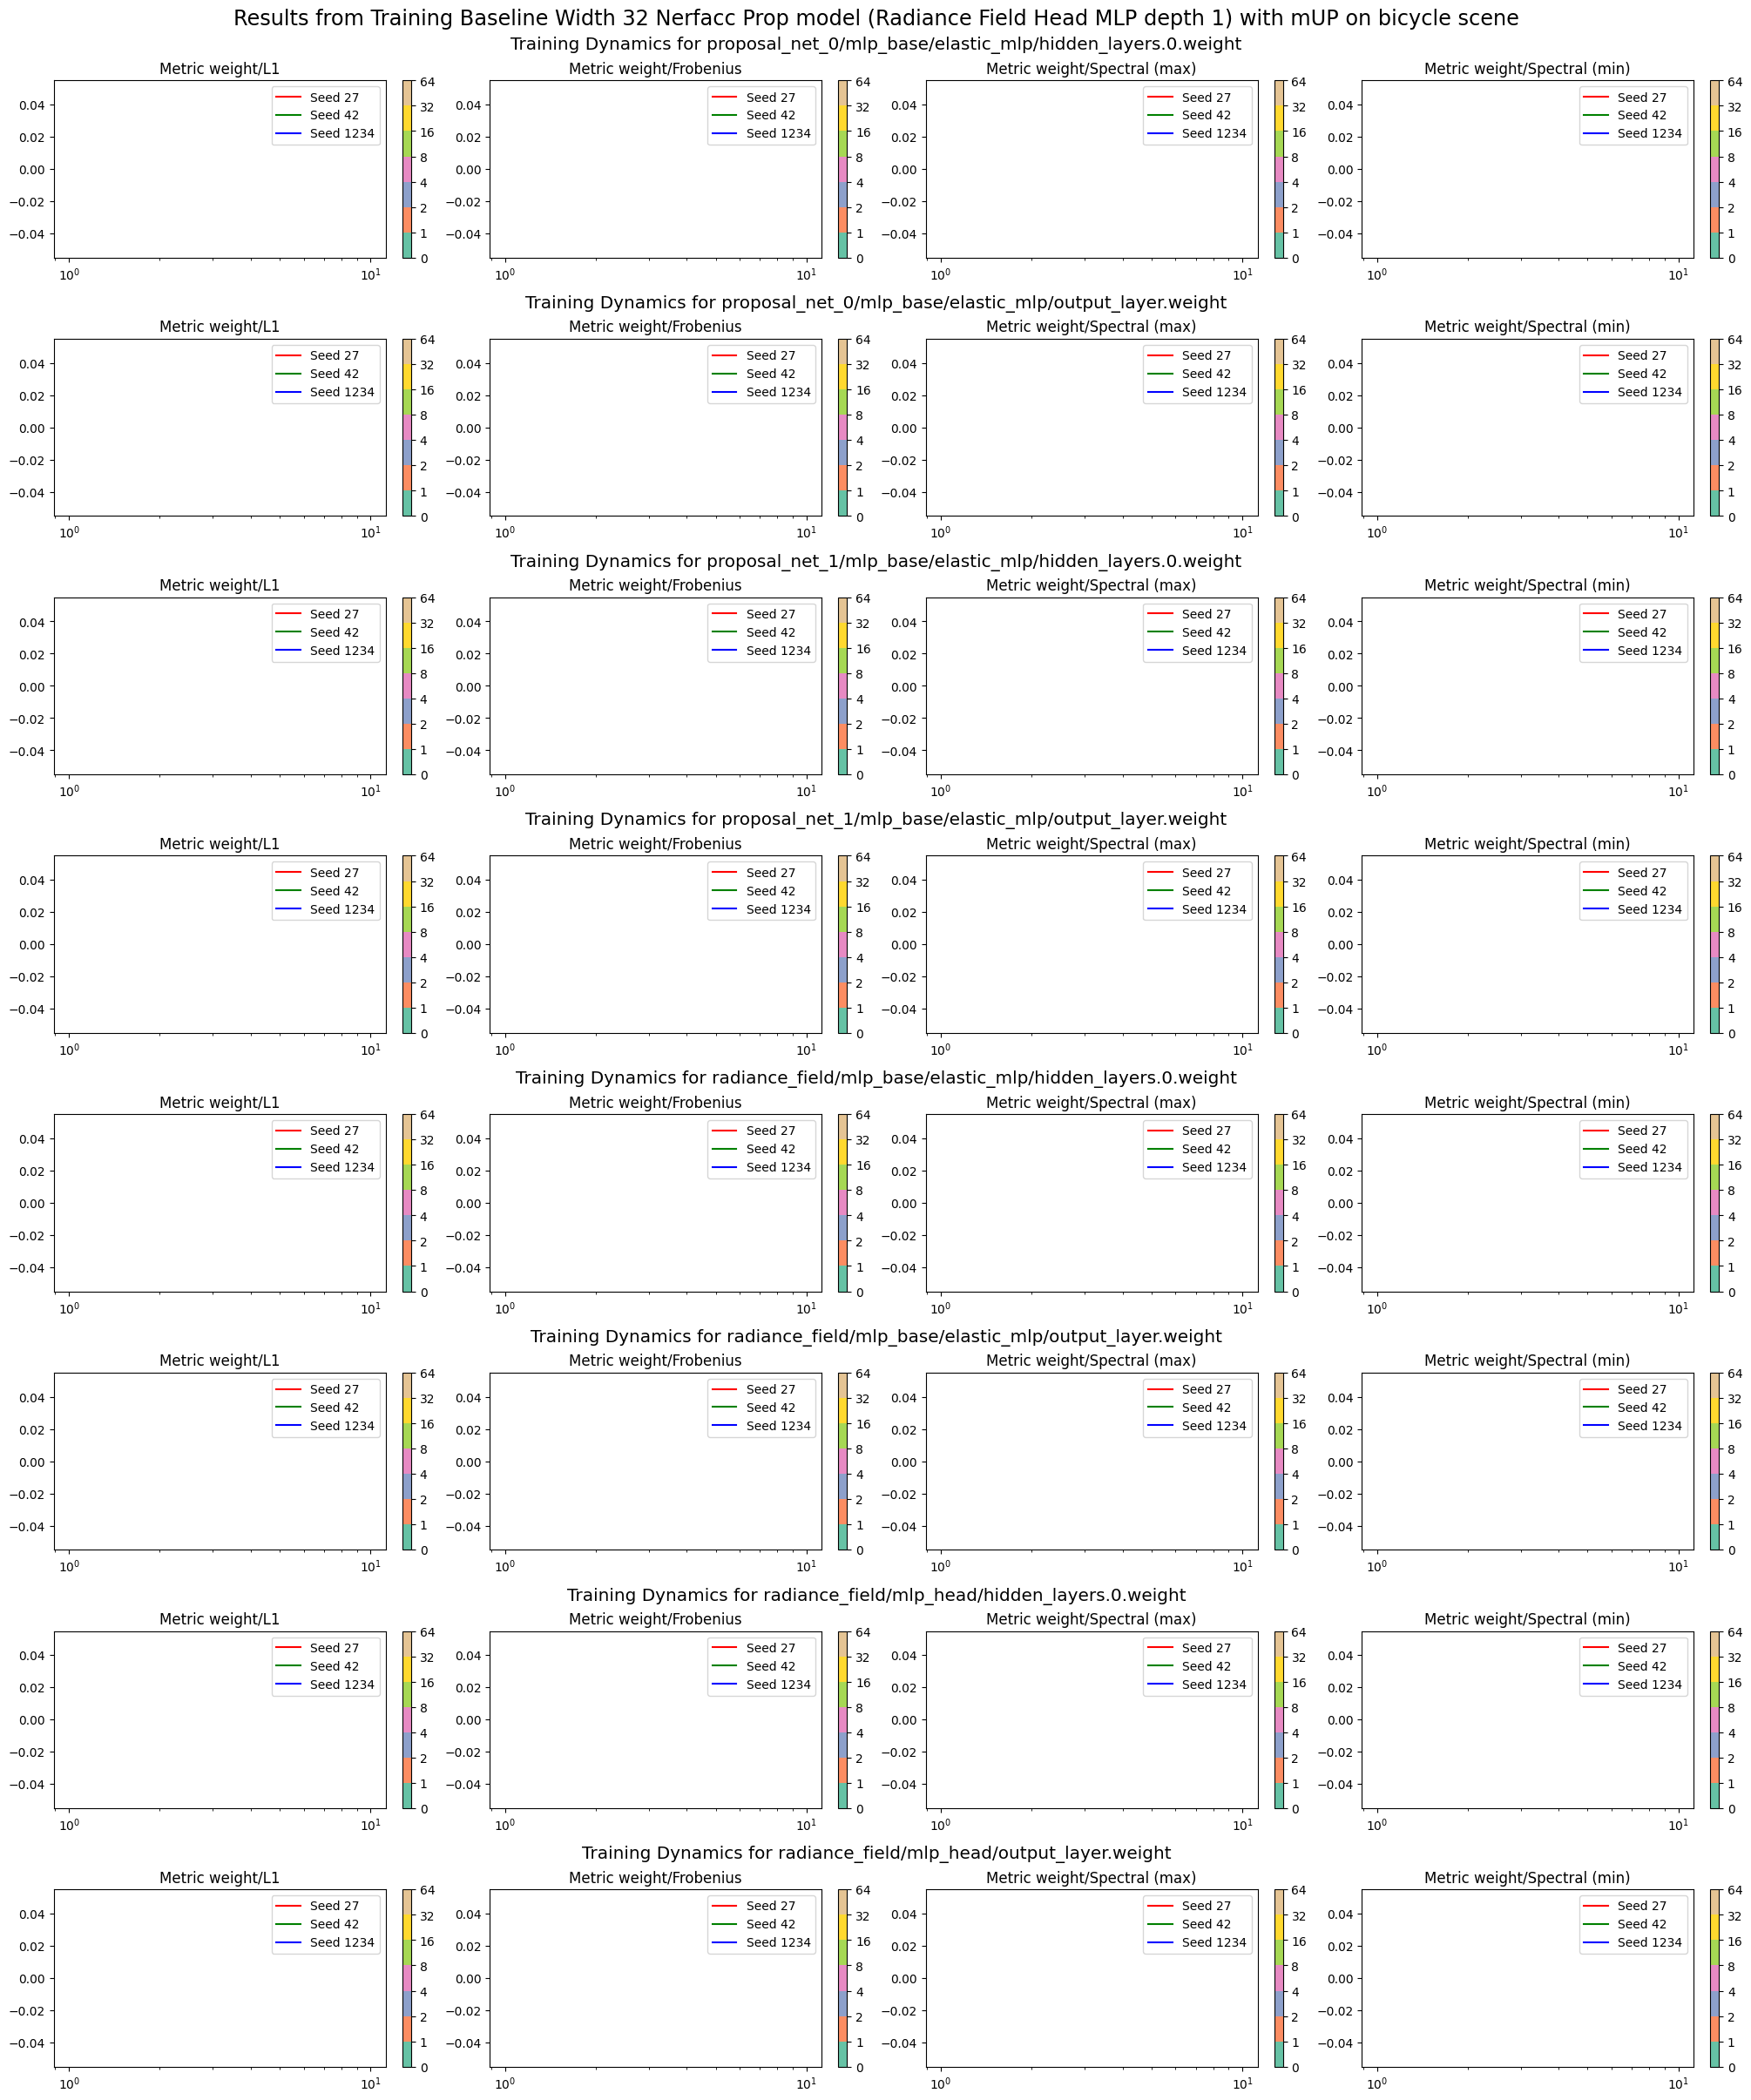

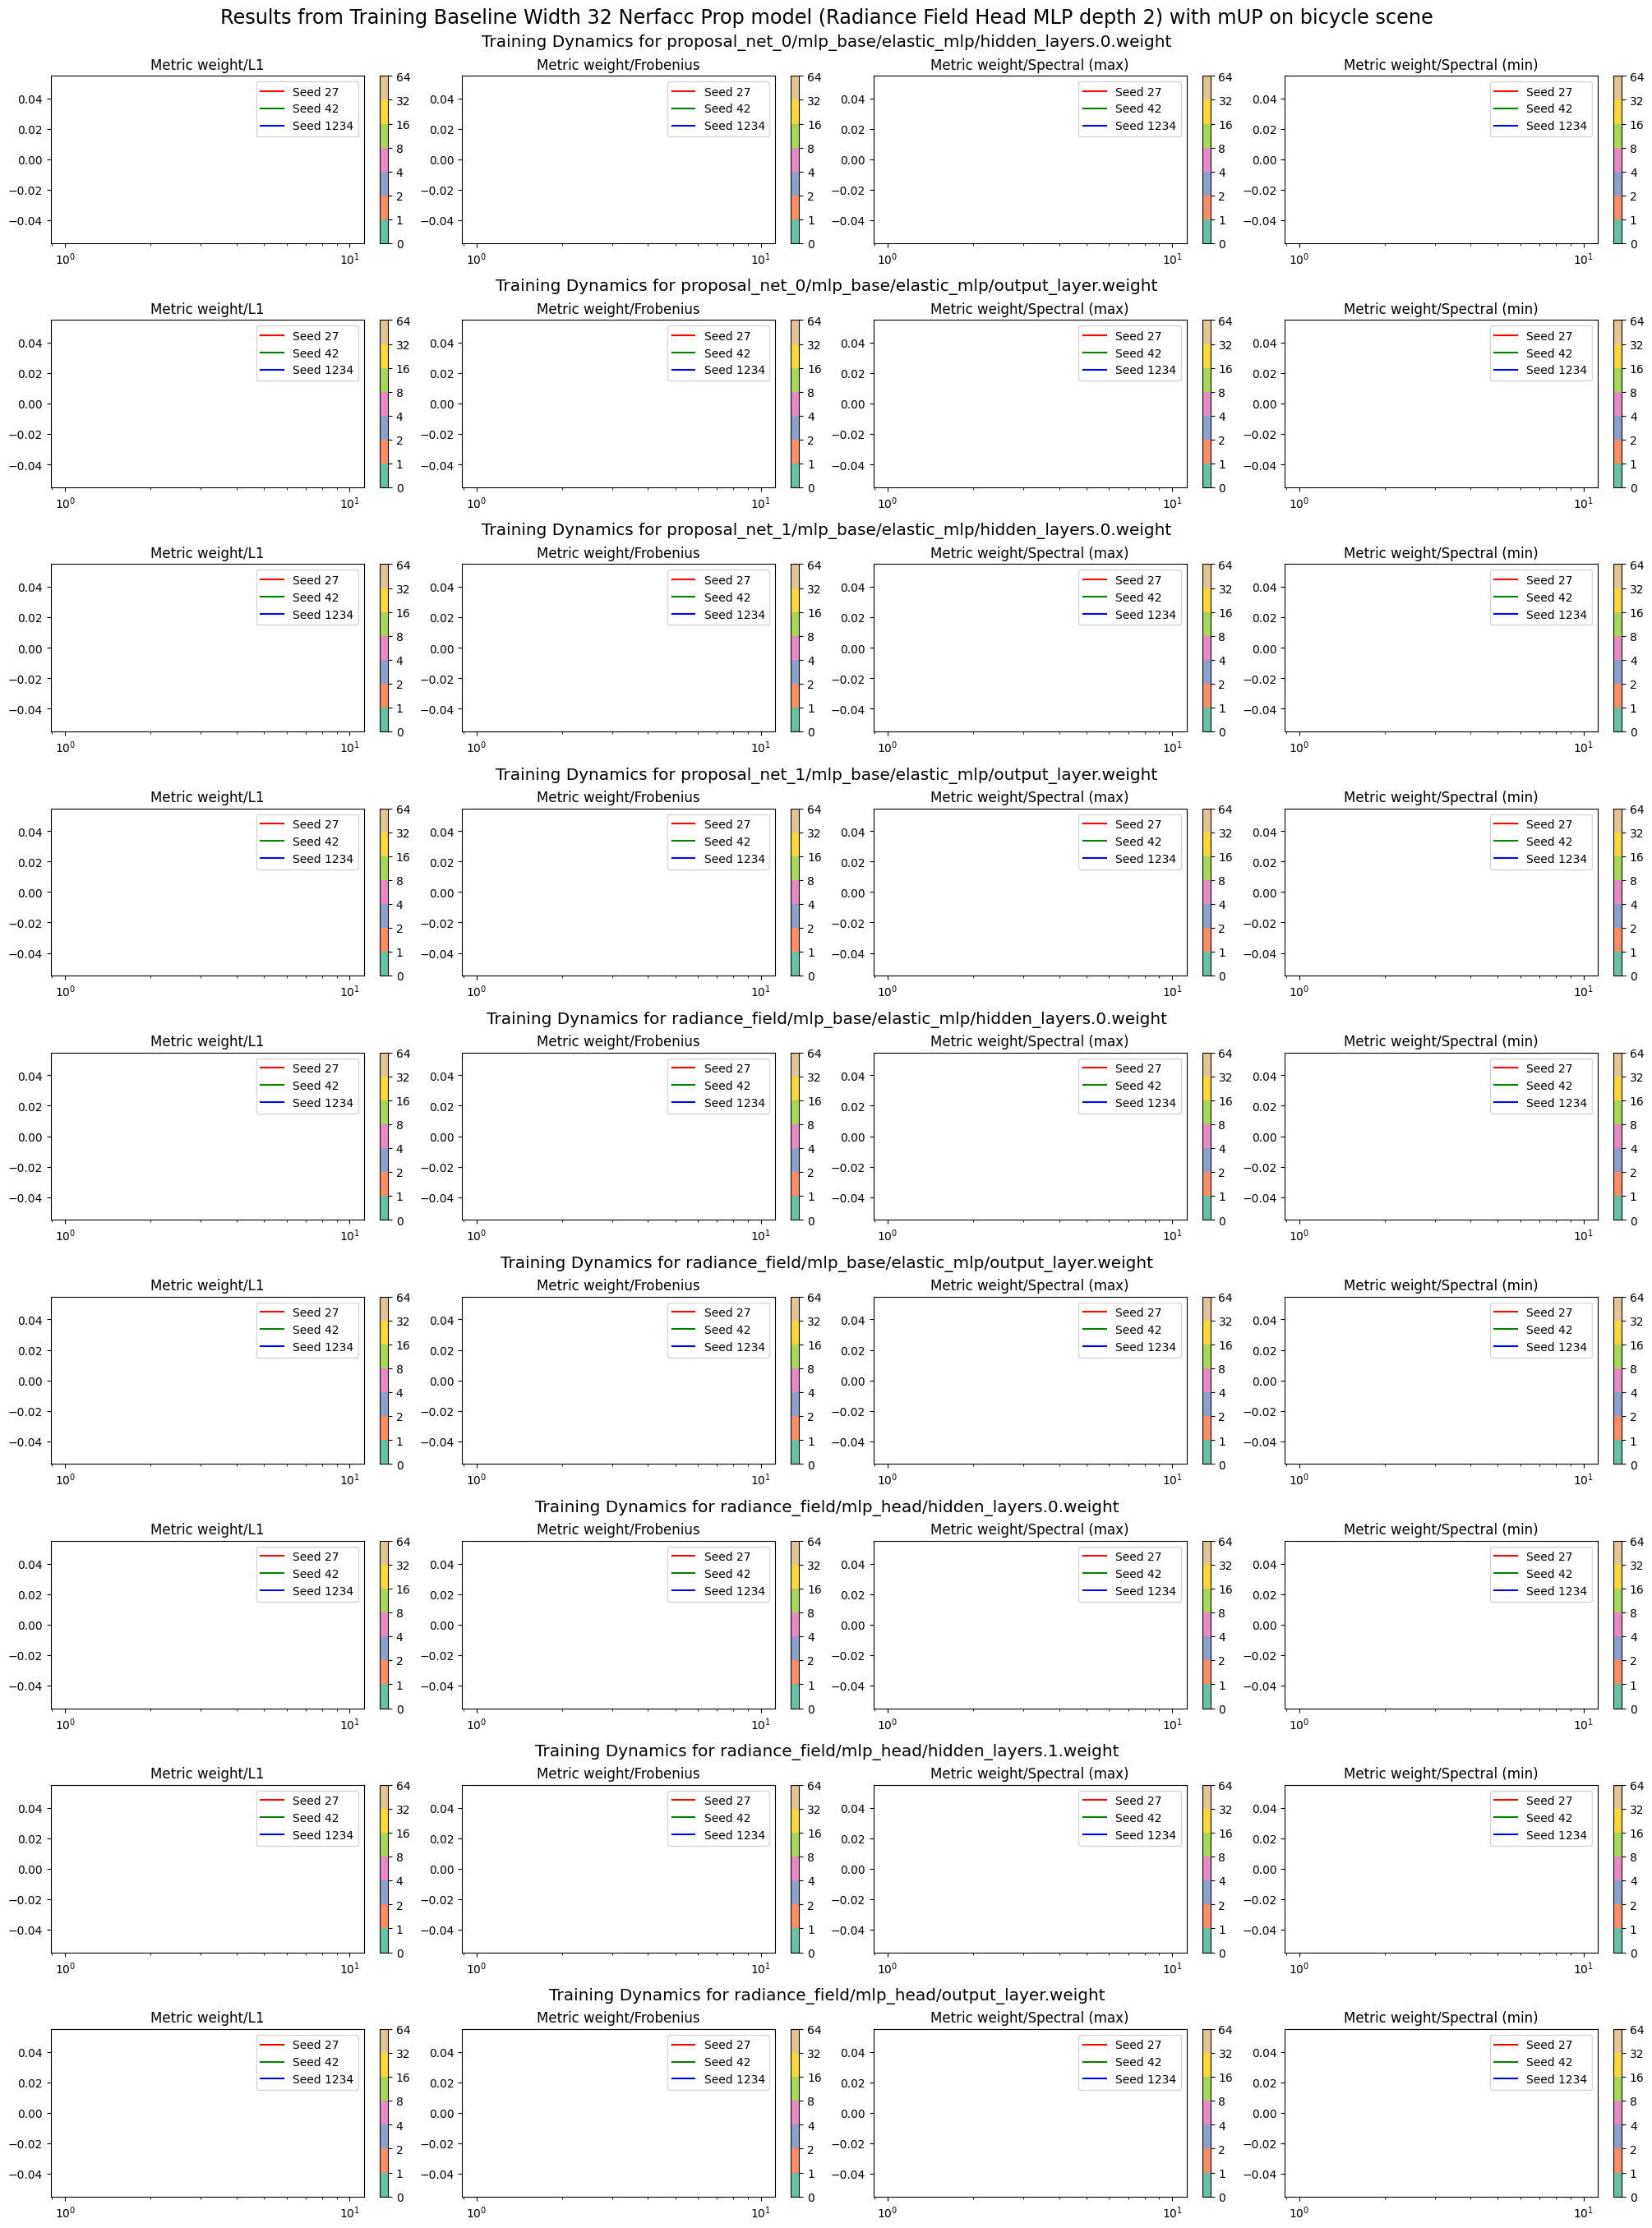

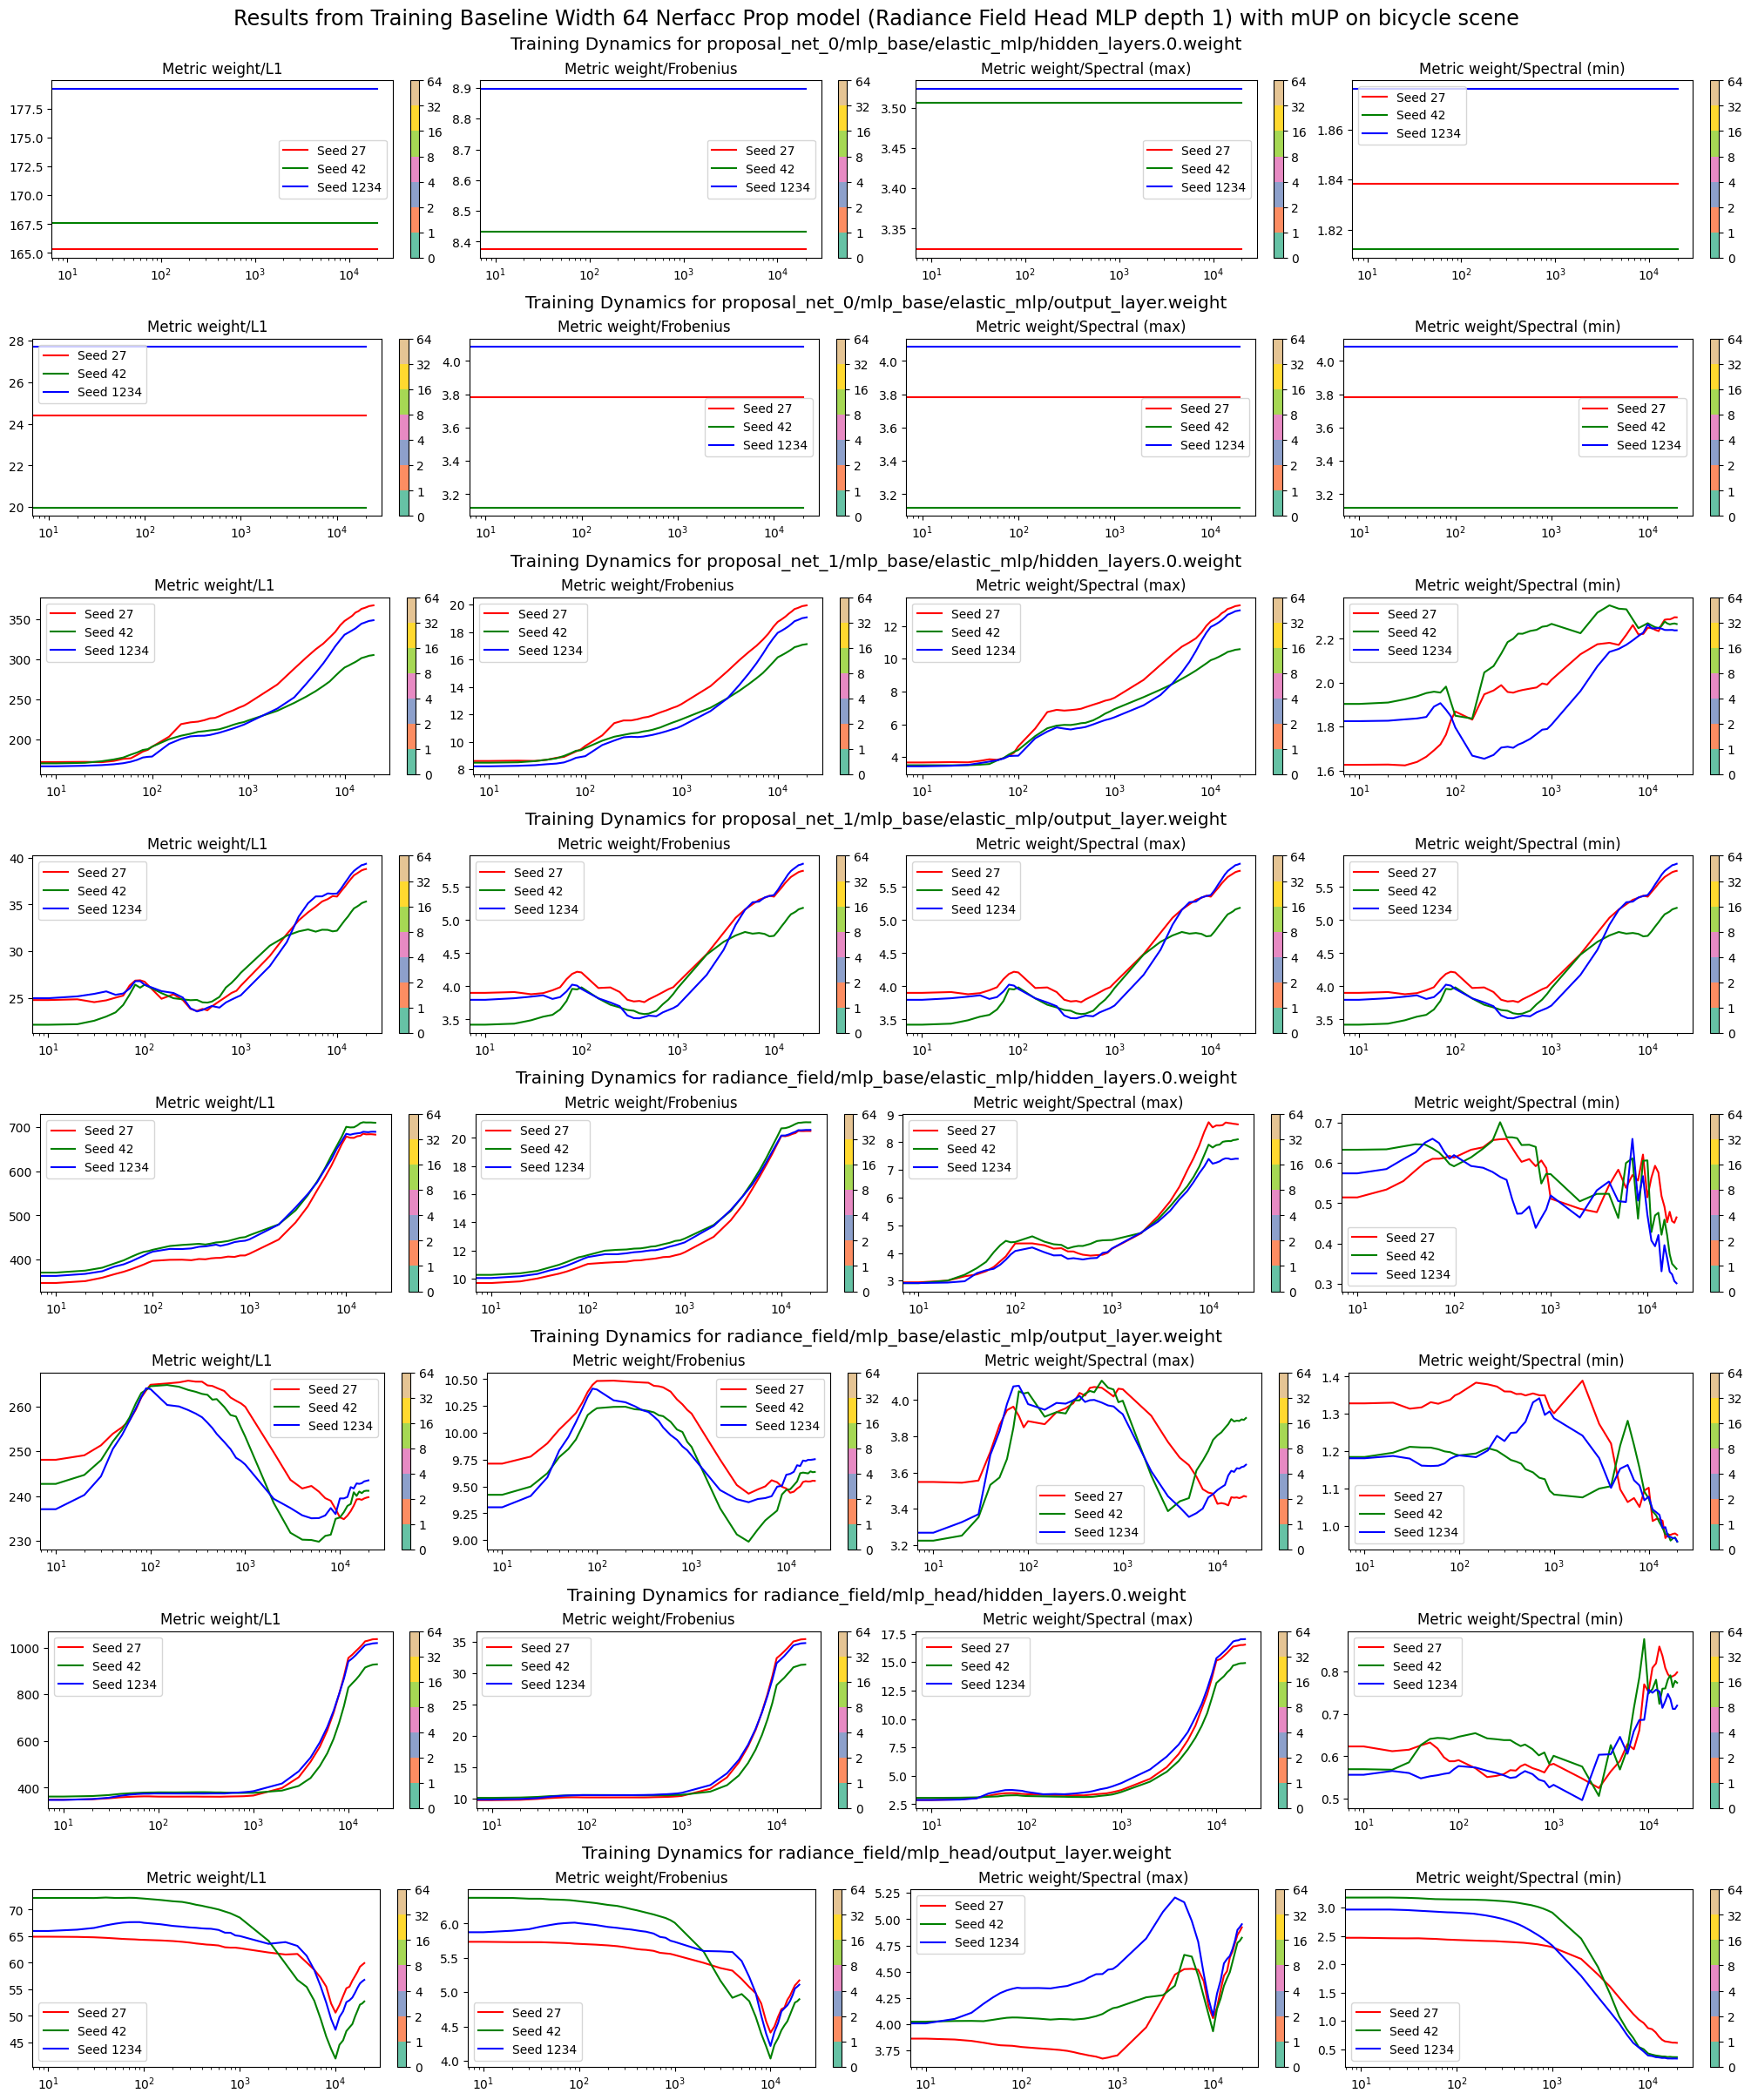

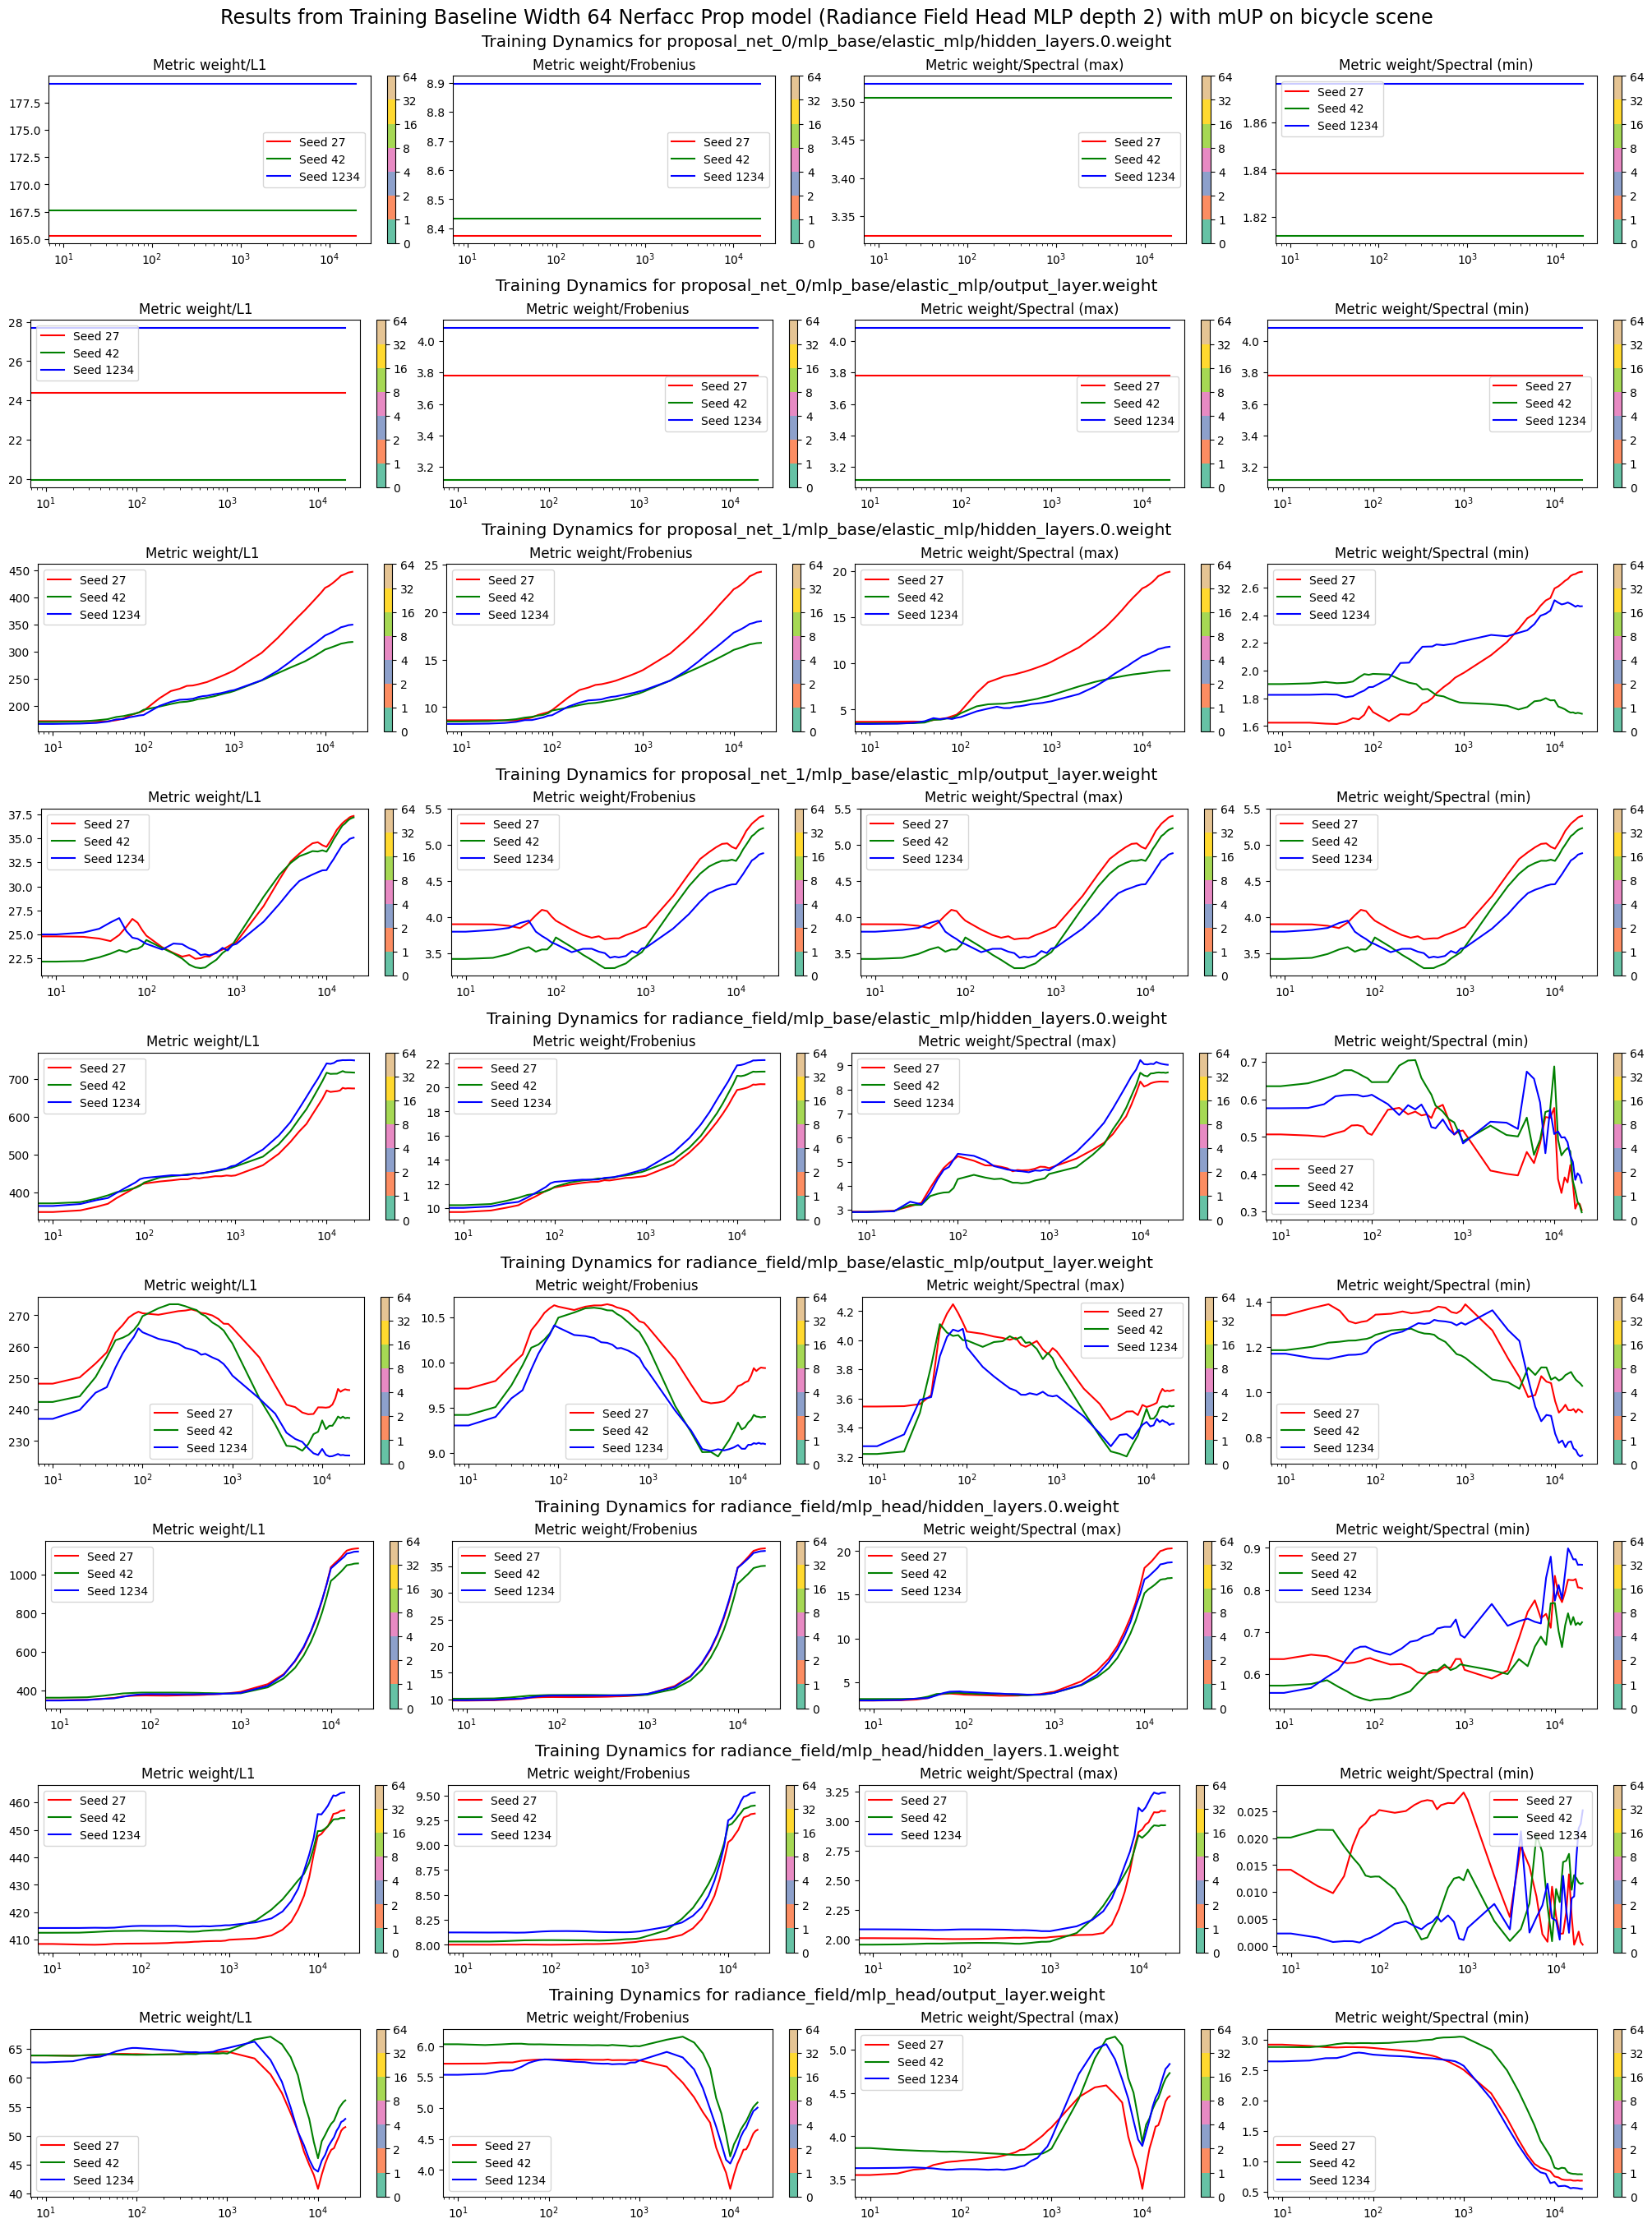

In [9]:
cc = ColorConfig()
metric_types = [
    "weight/L1",
    "weight/Frobenius",
    "weight/Spectral (max)",
    "weight/Spectral (min)",
]

for scene, scene_group in df.groupby(by="dataset.scene"):
    for model_type, model_type_group in scene_group.groupby(by="model_type"):
        for hidden_dim, hidden_dim_group in model_type_group.groupby(by="hidden_dim"):
            for head_depth, head_depth_group in hidden_dim_group.groupby(
                by="radiance_field.head_depth"
            ):
                fig = plt.figure(
                    layout="constrained",
                    figsize=(
                        5 * len(metric_types),
                        3 * len(head_depth_group["module"].unique()),
                    ),
                )
                model_type_name = (
                    "Nerfacc Occ" if "occ" in model_type else "Nerfacc Prop"
                )
                fig.suptitle(
                    f"Results from Training Baseline Width {hidden_dim} {model_type_name} model (Radiance Field Head MLP depth {head_depth}) with mUP on {scene} scene",
                    fontsize="xx-large",
                )
                colors = ["r", "g", "b"]
                subfigs = fig.subfigures(
                    len(head_depth_group["module"].unique()), 1, wspace=0.07
                )
                for i, (module, module_group) in enumerate(
                    head_depth_group.query("width == @hidden_dim").groupby(by="module")
                ):
                    subfig = subfigs[i]
                    subfig.suptitle(
                        f"Training Dynamics for {module}", fontsize="x-large"
                    )
                    subplots = subfig.subplots(1, len(metric_types))
                    for j, metric_type in enumerate(metric_types):
                        ax = subplots[j]
                        for k, (seed, seed_group) in enumerate(
                            module_group.groupby(by="seed")
                        ):
                            ax.plot(
                                width_group["step"],
                                seed_group[f"{metric_type}"],
                                color=colors[k],
                                label=f"Seed {seed}",
                            )
                        ax.set_xscale("log")
                        ax.set_title(f"Metric {metric_type}")
                        ax.legend()
                        cc.get_colorbar(ax)
    break

In [10]:
for hidden_dim, hidden_dim_group in model_type_group.groupby(by="hidden_dim"):
    for head_depth, head_depth_group in hidden_dim_group.groupby(
        by="radiance_field.head_depth"
    ):
        for i, (module, module_group) in enumerate(
            head_depth_group.query("width == @hidden_dim").groupby(by="module")
        ):
            break
        break
    break

In [11]:
module_group

seed   step  width  \
3283196  1234      0      8   
3283708  1234     10      8   
3284220  1234     20      8   
3284732  1234     30      8   
3285244  1234     40      8   
...       ...    ...    ...   
3346684    42  16000      8   
3347196    42  17000      8   
3347708    42  18000      8   
3348220    42  19000      8   
3348732    42  20000      8   

                                                    module sampling_strategy  \
3283196  proposal_net_0/mlp_base/elastic_mlp/hidden_lay...           uniform   
3283708  proposal_net_0/mlp_base/elastic_mlp/hidden_lay...           uniform   
3284220  proposal_net_0/mlp_base/elastic_mlp/hidden_lay...           uniform   
3284732  proposal_net_0/mlp_base/elastic_mlp/hidden_lay...           uniform   
3285244  proposal_net_0/mlp_base/elastic_mlp/hidden_lay...           uniform   
...                                                    ...               ...   
3346684  proposal_net_0/mlp_base/elastic_mlp/hidden_lay...           uniform   
3347196  proposal_net_0/mlp_base/elastic_mlp/hidden_lay...           uniform   
3347708  proposal_net_0/mlp_base/elastic_mlp/hidden_lay...           uniform   
3348220  proposal_net_0/mlp_base/elastic_mlp/hidden_lay...           uniform   
3348732  proposal_net_0/mlp_base/elastic_mlp/hidden_lay...           uniform   

        loss_weight_strategy  radiance_field.use_elastic  \
3283196              uniform                        True   
3283708              uniform                        True   
3284220              uniform                        True   
3284732              uniform                        True   
3285244              uniform                        True   
...                      ...                         ...   
3346684              uniform                        True   
3347196              uniform                        True   
3347708              uniform                        True   
3348220              uniform                        True   
3348732              uniform                        True   

         radiance_field.use_elastic_head  radiance_field.head_depth  \
3283196                             True                          1   
3283708                             True                          1   
3284220                             True                          1   
3284732                             True                          1   
3285244                             True                          1   
...                                  ...                        ...   
3346684                             True                          1   
3347196                             True                          1   
3347708                             True                          1   
3348220                             True                          1   
3348732                             True                          1   

        density_field.use_elastic  ...  grad/Frobenius grad_scaled/Frobenius  \
3283196                      True  ...             NaN                   NaN   
3283708                      True  ...             NaN                   NaN   
3284220                      True  ...             NaN                   NaN   
3284732                      True  ...             NaN                   NaN   
3285244                      True  ...             NaN                   NaN   
...                           ...  ...             ...                   ...   
3346684                      True  ...             NaN                   NaN   
3347196                      True  ...             NaN                   NaN   
3347708                      True  ...             NaN                   NaN   
3348220                      True  ...             NaN                   NaN   
3348732                      True  ...             NaN                   NaN   

         weight/Spectral (max)  weight_scaled/Spectral (max)  \
3283196                    NaN                           NaN   
3283708     